# Cell 1: Environment Setup

In [ ]:
# Install required packages
!pip install -q sentence-transformers faiss-cpu pandas numpy scikit-learn matplotlib seaborn tqdm
!pip install -q transformers torch datasets
!pip install -q langdetect  # For multilingual support
!pip install -q textblob vaderSentiment  # Alternative sentiment classifiers

# Verify installations
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import faiss
from sentence_transformers import SentenceTransformer
from transformers import pipeline, AutoTokenizer, AutoModelForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
import time
from collections import defaultdict
import json

# For multilingual support
from langdetect import detect

# Alternative sentiment analyzers
from textblob import TextBlob
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

print("✓ All packages installed successfully")
print(f"FAISS version: {faiss.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✓ All packages installed successfully
FAISS version: 1.13.2
NumPy version: 2.0.2
Pandas version: 2.2.2


# Cell 2: Load Primary Dataset (IMDB)

In [ ]:
DATASET_PATH = '/content/IMDB Dataset.csv'
df = pd.read_csv(DATASET_PATH)
print(f"Dataset loaded successfully from: {DATASET_PATH}")

# Basic exploration
print(f"\nDataset shape: {df.shape}")
print(f"Columns: {df.columns.tolist()}")
print(f"\nFirst few rows:")
print(df.head())
print(f"\nSentiment distribution:")
print(df['sentiment'].value_counts())
print(f"\nMissing values:")
print(df.isnull().sum())

Dataset loaded successfully from: /content/IMDB Dataset.csv

Dataset shape: (50000, 2)
Columns: ['review', 'sentiment']

First few rows:
                                              review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Basically there's a family where a little boy ...  negative
4  Petter Mattei's "Love in the Time of Money" is...  positive

Sentiment distribution:
sentiment
positive    25000
negative    25000
Name: count, dtype: int64

Missing values:
review       0
sentiment    0
dtype: int64


# Cell 3: Data Preprocessing with Language Detection

In [ ]:
# Enhanced preprocessing with language detection
def preprocess_text(text):
    if pd.isna(text):
        return ""
    return str(text).strip()

def detect_language(text):
    """Detect language of the text"""
    try:
        return detect(text)
    except:
        return 'unknown'

# Apply preprocessing
df['review'] = df['review'].apply(preprocess_text)
df = df[df['review'].str.len() > 0].copy()

# Remove duplicates
initial_count = len(df)
df = df.drop_duplicates(subset=['review']).reset_index(drop=True)
print(f"Removed {initial_count - len(df)} duplicates")

# Map sentiment labels
sentiment_mapping = {'positive': 1, 'negative': 0}
df['sentiment_label'] = df['sentiment'].map(sentiment_mapping)

# Language detection (sample for efficiency)
print("\nDetecting languages in sample...")
sample_df = df.sample(min(1000, len(df)), random_state=42)
sample_df['language'] = sample_df['review'].apply(detect_language)
print("\nLanguage distribution in sample:")
print(sample_df['language'].value_counts())

# Stratified train-test split
train_df, test_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    stratify=df['sentiment_label']
)

print(f"\nTrain set size: {len(train_df)}")
print(f"Test set size: {len(test_df)}")
print(f"\nTrain sentiment distribution:")
print(train_df['sentiment_label'].value_counts())
print(f"\nTest sentiment distribution:")
print(test_df['sentiment_label'].value_counts())

# Save preprocessed data
train_df.to_csv('train_data.csv', index=False)
test_df.to_csv('test_data.csv', index=False)
print("\n✓ Preprocessing complete and data saved")

Removed 418 duplicates

Detecting languages in sample...

Language distribution in sample:
language
en    1000
Name: count, dtype: int64

Train set size: 44623
Test set size: 4959

Train sentiment distribution:
sentiment_label
1    22395
0    22228
Name: count, dtype: int64

Test sentiment distribution:
sentiment_label
1    2489
0    2470
Name: count, dtype: int64

✓ Preprocessing complete and data saved


# Cell 4: Generate Embeddings

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║                    Cell 4: Generate Embeddings                              ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

from sentence_transformers import SentenceTransformer

# ── Load embedding model ──────────────────────────────────────────────────────
print("LOADING EMBEDDING MODEL")
embedding_model = SentenceTransformer('all-MiniLM-L6-v2')
print(f"Model loaded: all-MiniLM-L6-v2")
print(f"Embedding dimension: {embedding_model.get_sentence_embedding_dimension()}")

# ── Batch encoding helper ─────────────────────────────────────────────────────
batch_size = 256   # matches your original Cell 8; use 64 if GPU memory is tight

# ── Training set ──────────────────────────────────────────────────────────────
print("\nGENERATING EMBEDDINGS FOR TRAINING SET")
print(f"Processing {len(train_df):,} training reviews...")

start_time = time.time()
embeddings_train = embedding_model.encode(
    train_df['review'].tolist(),   # ← FIX 1: 'review' not 'review'
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True
)
train_time = time.time() - start_time

print(f"\nTraining embeddings generated")
print(f"  Shape        : {embeddings_train.shape}")
print(f"  Memory usage : {embeddings_train.nbytes / 1024**2:.2f} MB")
print(f"  Time taken   : {train_time:.2f}s")

# ── Test set ──────────────────────────────────────────────────────────────────
print("\nGENERATING EMBEDDINGS FOR TEST SET")
print(f"Processing {len(test_df):,} test reviews...")

start_time = time.time()
embeddings_test = embedding_model.encode(
    test_df['review'].tolist(),    #
    batch_size=batch_size,
    show_progress_bar=True,
    convert_to_numpy=True
)
test_time = time.time() - start_time

print(f"\nTest embeddings generated")
print(f"  Shape        : {embeddings_test.shape}")
print(f"  Memory usage : {embeddings_test.nbytes / 1024**2:.2f} MB")
print(f"  Time taken   : {test_time:.2f}s")

# ── L2 normalise (unit vectors → inner-product == cosine similarity) ──────────
# FIX 2: store normalised arrays under the names Cell 5, 8, 9, 10 all expect
embeddings_train_normalized = embeddings_train / np.linalg.norm(
    embeddings_train, axis=1, keepdims=True
)
embeddings_test_normalized = embeddings_test / np.linalg.norm(
    embeddings_test, axis=1, keepdims=True
)

# ── Verify normalisation ──────────────────────────────────────────────────────
train_norms = np.linalg.norm(embeddings_train_normalized, axis=1)
test_norms  = np.linalg.norm(embeddings_test_normalized,  axis=1)

print("\nEMBEDDINGS SUMMARY")
print(f"Training embeddings : {embeddings_train_normalized.shape}")
print(f"Test embeddings     : {embeddings_test_normalized.shape}")
print(
    f"Total memory        : "
    f"{(embeddings_train_normalized.nbytes + embeddings_test_normalized.nbytes) / 1024**2:.2f} MB"
)
print(
    f"Train norms — mean  : {train_norms.mean():.6f}  "
    f"std: {train_norms.std():.8f}"
)
print(
    f"Test  norms — mean  : {test_norms.mean():.6f}  "
    f"std: {test_norms.std():.8f}"
)
print(f"Train all unit-norm : {np.allclose(train_norms, 1.0)}")
print(f"Test  all unit-norm : {np.allclose(test_norms,  1.0)}")
print("All embeddings normalized for cosine similarity")

# ── FIX 3: save under the correct filenames used by Cell 11 (dashboard) ───────
np.save('embeddings_normalized.npy', embeddings_train_normalized)   # dashboard file
np.save('embeddings_train.npy',      embeddings_train_normalized)   # optional backup
np.save('embeddings_test.npy',       embeddings_test_normalized)    # optional backup

print("\n✓ Embeddings generated, normalised, and saved")

LOADING EMBEDDING MODEL


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Model loaded: all-MiniLM-L6-v2
Embedding dimension: 384

GENERATING EMBEDDINGS FOR TRAINING SET
Processing 44,623 training reviews...


Batches:   0%|          | 0/175 [00:00<?, ?it/s]


Training embeddings generated
  Shape        : (44623, 384)
  Memory usage : 65.37 MB
  Time taken   : 170.16s

GENERATING EMBEDDINGS FOR TEST SET
Processing 4,959 test reviews...


Batches:   0%|          | 0/20 [00:00<?, ?it/s]


Test embeddings generated
  Shape        : (4959, 384)
  Memory usage : 7.26 MB
  Time taken   : 17.63s

EMBEDDINGS SUMMARY
Training embeddings : (44623, 384)
Test embeddings     : (4959, 384)
Total memory        : 72.63 MB
Train norms — mean  : 1.000000  std: 0.00000002
Test  norms — mean  : 1.000000  std: 0.00000002
Train all unit-norm : True
Test  all unit-norm : True
All embeddings normalized for cosine similarity

✓ Embeddings generated, normalised, and saved


# Cell 5: Build FAISS Indexes (All 4 Types)

In [ ]:
# Build multiple FAISS indexes for comparison
print("BUILDING FAISS INDEXES (4 TYPES)")

dimension = embeddings_train.shape[1]
n_vectors = len(embeddings_train)

indexes = {}
index_configs = {}

# 1. FlatL2 - Exact search baseline
print("\n1. Building FlatL2 (exact search)...")
index_flat = faiss.IndexFlatL2(dimension)
index_flat.add(embeddings_train.astype('float32'))
indexes['flatl2'] = index_flat
index_configs['flatl2'] = {'type': 'exact', 'params': {}}
print(f"   FlatL2 index built: {index_flat.ntotal} vectors")

# 2. IVF - Inverted File Index
print("\n2. Building IVF index...")
nlist = 100  # number of clusters
quantizer = faiss.IndexFlatL2(dimension)
index_ivf = faiss.IndexIVFFlat(quantizer, dimension, nlist)
index_ivf.train(embeddings_train.astype('float32'))
index_ivf.add(embeddings_train.astype('float32'))
index_ivf.nprobe = 10  # number of clusters to search
indexes['ivf'] = index_ivf
index_configs['ivf'] = {'type': 'ivf', 'params': {'nlist': nlist, 'nprobe': 10}}
print(f"   IVF index built: {index_ivf.ntotal} vectors, nlist={nlist}, nprobe={index_ivf.nprobe}")

# 3. HNSW - Hierarchical Navigable Small World
print("\n3. Building HNSW index...")
M = 32  # number of connections per layer
index_hnsw = faiss.IndexHNSWFlat(dimension, M)
index_hnsw.hnsw.efConstruction = 40
index_hnsw.hnsw.efSearch = 16
index_hnsw.add(embeddings_train.astype('float32'))
indexes['hnsw'] = index_hnsw
index_configs['hnsw'] = {'type': 'hnsw', 'params': {'M': M, 'efConstruction': 40, 'efSearch': 16}}
print(f"   HNSW index built: {index_hnsw.ntotal} vectors, M={M}")

# 4. IVFPQ - IVF with Product Quantization
print("\n4. Building IVFPQ index (compressed)...")
nlist_pq = 100
m = 8  # number of subquantizers
bits = 8  # bits per subquantizer
quantizer_pq = faiss.IndexFlatL2(dimension)
index_ivfpq = faiss.IndexIVFPQ(quantizer_pq, dimension, nlist_pq, m, bits)
index_ivfpq.train(embeddings_train.astype('float32'))
index_ivfpq.add(embeddings_train.astype('float32'))
index_ivfpq.nprobe = 10
indexes['ivfpq'] = index_ivfpq
index_configs['ivfpq'] = {'type': 'ivfpq', 'params': {'nlist': nlist_pq, 'nprobe': 10, 'm': m, 'bits': bits}}
print(f"   IVFPQ index built: {index_ivfpq.ntotal} vectors, m={m}, bits={bits}")

# Print index sizes
print("\n" + "="*60)
print("INDEX SUMMARY")
print("="*60)
for name, idx in indexes.items():
    print(f"{name.upper():10s}: {idx.ntotal:,} vectors | Config: {index_configs[name]['params']}")

print("\n✓ All FAISS indexes built successfully")

BUILDING FAISS INDEXES (4 TYPES)

1. Building FlatL2 (exact search)...
   FlatL2 index built: 44623 vectors

2. Building IVF index...
   IVF index built: 44623 vectors, nlist=100, nprobe=10

3. Building HNSW index...
   HNSW index built: 44623 vectors, M=32

4. Building IVFPQ index (compressed)...
   IVFPQ index built: 44623 vectors, m=8, bits=8

INDEX SUMMARY
FLATL2    : 44,623 vectors | Config: {}
IVF       : 44,623 vectors | Config: {'nlist': 100, 'nprobe': 10}
HNSW      : 44,623 vectors | Config: {'M': 32, 'efConstruction': 40, 'efSearch': 16}
IVFPQ     : 44,623 vectors | Config: {'nlist': 100, 'nprobe': 10, 'm': 8, 'bits': 8}

✓ All FAISS indexes built successfully


# Cell 6: Enhanced Sentiment Classifiers (Multiple Models for Comparison)

In [ ]:
print("="*60)
print("LOADING SENTIMENT CLASSIFIERS FOR COMPARISON")
print("="*60)

# 1. Primary: DistilBERT (used in paper)
print("\n1. Loading DistilBERT-SST2...")
distilbert_classifier = pipeline(
    "sentiment-analysis",
    model="distilbert-base-uncased-finetuned-sst-2-english",
    device=-1  # CPU
)
print("   ✓ DistilBERT loaded")

# 2. Alternative: RoBERTa
print("\n2. Loading RoBERTa-sentiment...")
try:
    roberta_classifier = pipeline(
        "sentiment-analysis",
        model="cardiffnlp/twitter-roberta-base-sentiment",
        device=-1
    )
    print("   ✓ RoBERTa loaded")
except:
    print("   ⚠ RoBERTa not available, skipping")
    roberta_classifier = None

# 3. VADER (lexicon-based)
print("\n3. Loading VADER...")
vader_analyzer = SentimentIntensityAnalyzer()
print("   ✓ VADER loaded")

# 4. TextBlob (simpler baseline)
print("\n4. TextBlob available")

# Unified sentiment prediction function
def predict_sentiment_distilbert(text, threshold=0.7):
    """DistilBERT prediction"""
    # Ensure truncation is handled by the pipeline itself
    result = distilbert_classifier(text, truncation=True, max_length=512)[0]
    label = 1 if result['label'] == 'POSITIVE' else 0
    confidence = result['score']
    return label, confidence

def predict_sentiment_vader(text, threshold=0.05):
    """VADER prediction"""
    scores = vader_analyzer.polarity_scores(text)
    compound = scores['compound']

    if compound >= threshold:
        label = 1
        confidence = (compound + 1) / 2  # Normalize to [0,1]
    elif compound <= -threshold:
        label = 0
        confidence = (1 - compound) / 2
    else:
        label = 1  # Neutral defaults to positive
        confidence = 0.5

    return label, confidence

def predict_sentiment_textblob(text):
    """TextBlob prediction"""
    polarity = TextBlob(text).sentiment.polarity
    label = 1 if polarity >= 0 else 0
    confidence = abs(polarity)
    return label, confidence

print("\n✓ All sentiment classifiers ready")

LOADING SENTIMENT CLASSIFIERS FOR COMPARISON

1. Loading DistilBERT-SST2...


Loading weights:   0%|          | 0/104 [00:00<?, ?it/s]

   ✓ DistilBERT loaded

2. Loading RoBERTa-sentiment...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: cardiffnlp/twitter-roberta-base-sentiment
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


   ✓ RoBERTa loaded

3. Loading VADER...
   ✓ VADER loaded

4. TextBlob available

✓ All sentiment classifiers ready


# Cell 7: Threshold Sensitivity Analysis

THRESHOLD SENSITIVITY ANALYSIS


Testing thresholds:   0%|          | 0/8 [00:00<?, ?it/s]


Threshold Sensitivity Results:
 threshold  filtered_count  retention_rate  accuracy  avg_confidence
      0.50             100            1.00  0.920000        0.976125
      0.60             100            1.00  0.920000        0.976125
      0.70              98            0.98  0.918367        0.982706
      0.75              98            0.98  0.918367        0.982706
      0.80              97            0.97  0.927835        0.984786
      0.85              95            0.95  0.936842        0.987946
      0.90              91            0.91  0.956044        0.992463
      0.95              88            0.88  0.954545        0.994095


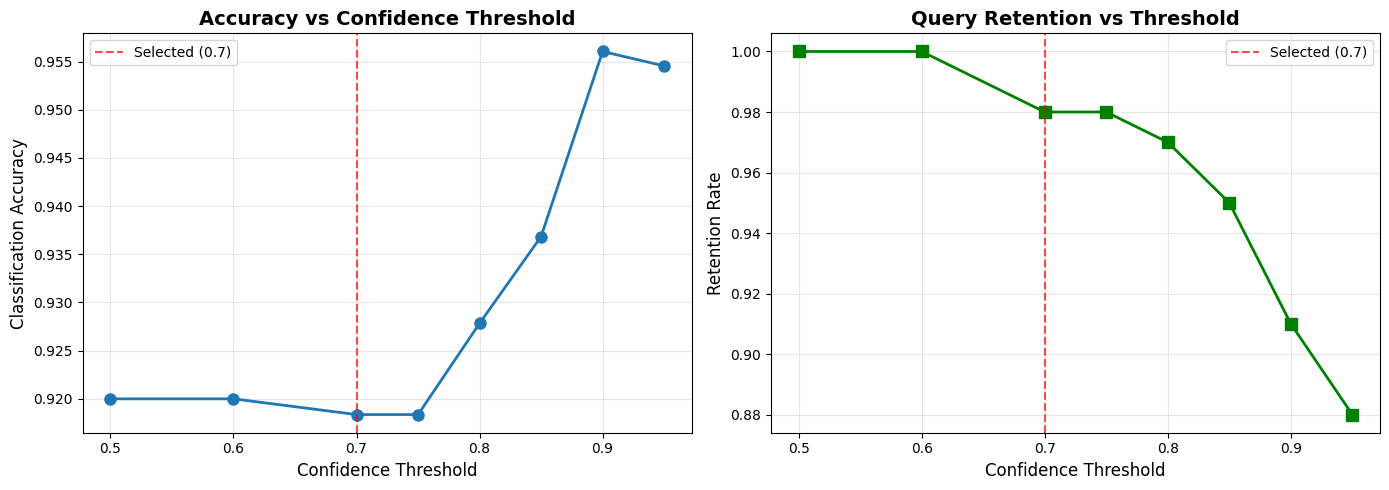


OPTIMAL THRESHOLD: 0.5
Accuracy: 0.9200
Retention Rate: 1.0000
F1 Score: 0.9583

✓ Threshold analysis complete


In [ ]:
print("="*60)
print("THRESHOLD SENSITIVITY ANALYSIS")
print("="*60)

# Test different confidence thresholds
thresholds = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# Sample test queries
test_queries_sample = test_df.sample(min(100, len(test_df)), random_state=42)

threshold_results = []

for threshold in tqdm(thresholds, desc="Testing thresholds"):
    filtered_count = 0
    correct_predictions = 0
    total_confidence = 0

    for idx, row in test_queries_sample.iterrows():
        text = row['review']
        # Truncate text to avoid exceeding model's max sequence length
        # DistilBERT has a max sequence length of 512. A rough estimate for characters is 2000.
        text_truncated = text[:2000] # Ensure text is not too long for the model
        true_label = row['sentiment_label']

        pred_label, confidence = predict_sentiment_distilbert(text_truncated, threshold) # Use truncated text

        if confidence >= threshold:
            filtered_count += 1
            if pred_label == true_label:
                correct_predictions += 1
            total_confidence += confidence

    if filtered_count > 0:
        accuracy = correct_predictions / filtered_count
        avg_confidence = total_confidence / filtered_count
        retention_rate = filtered_count / len(test_queries_sample)
    else:
        accuracy = 0
        avg_confidence = 0
        retention_rate = 0

    threshold_results.append({
        'threshold': threshold,
        'filtered_count': filtered_count,
        'retention_rate': retention_rate,
        'accuracy': accuracy,
        'avg_confidence': avg_confidence
    })

# Convert to DataFrame
threshold_df = pd.DataFrame(threshold_results)

print("\nThreshold Sensitivity Results:")
print(threshold_df.to_string(index=False))

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Accuracy vs Threshold
axes[0].plot(threshold_df['threshold'], threshold_df['accuracy'], marker='o', linewidth=2, markersize=8)
axes[0].set_xlabel('Confidence Threshold', fontsize=12)
axes[0].set_ylabel('Classification Accuracy', fontsize=12)
axes[0].set_title('Accuracy vs Confidence Threshold', fontsize=14, fontweight='bold')
axes[0].grid(True, alpha=0.3)
axes[0].axvline(x=0.7, color='red', linestyle='--', label='Selected (0.7)', alpha=0.7)
axes[0].legend()

# Plot 2: Retention Rate vs Threshold
axes[1].plot(threshold_df['threshold'], threshold_df['retention_rate'], marker='s', linewidth=2, markersize=8, color='green')
axes[1].set_xlabel('Confidence Threshold', fontsize=12)
axes[1].set_ylabel('Retention Rate', fontsize=12)
axes[1].set_title('Query Retention vs Threshold', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)
axes[1].axvline(x=0.7, color='red', linestyle='--', label='Selected (0.7)', alpha=0.7)
axes[1].legend()

plt.tight_layout()
plt.savefig('threshold_sensitivity_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Find optimal threshold (balance accuracy and retention)
threshold_df['f1_score'] = 2 * (threshold_df['accuracy'] * threshold_df['retention_rate']) / \
                           (threshold_df['accuracy'] + threshold_df['retention_rate'] + 1e-10)
optimal_idx = threshold_df['f1_score'].idxmax()
optimal_threshold = threshold_df.loc[optimal_idx, 'threshold']

print(f"\n{'='*60}")
print(f"OPTIMAL THRESHOLD: {optimal_threshold}")
print(f"Accuracy: {threshold_df.loc[optimal_idx, 'accuracy']:.4f}")
print(f"Retention Rate: {threshold_df.loc[optimal_idx, 'retention_rate']:.4f}")
print(f"F1 Score: {threshold_df.loc[optimal_idx, 'f1_score']:.4f}")
print(f"{'='*60}")

# Save results
threshold_df.to_csv('threshold_sensitivity_results.csv', index=False)
print("\n✓ Threshold analysis complete")

# Cell 8: Classifier Comparison Study

SENTIMENT CLASSIFIER COMPARISON

Testing DistilBERT...


DistilBERT:   0%|          | 0/500 [00:00<?, ?it/s]

  Accuracy: 0.9020
  F1 Score: 0.8909
  Avg Latency: 353.24ms

Testing VADER...


VADER:   0%|          | 0/500 [00:00<?, ?it/s]

  Accuracy: 0.6600
  F1 Score: 0.6898
  Avg Latency: 3.27ms

Testing TextBlob...


TextBlob:   0%|          | 0/500 [00:00<?, ?it/s]

  Accuracy: 0.6500
  F1 Score: 0.7107
  Avg Latency: 1.49ms

CLASSIFIER PERFORMANCE COMPARISON
            accuracy  precision  recall      f1  avg_confidence  avg_latency_ms  std_latency_ms
DistilBERT     0.902     0.8889  0.8929  0.8909          0.9730        353.2393        256.4565
VADER          0.660     0.5833  0.8438  0.6898          0.9200          3.2711          5.5856
TextBlob       0.650     0.5643  0.9598  0.7107          0.1571          1.4897          2.2744


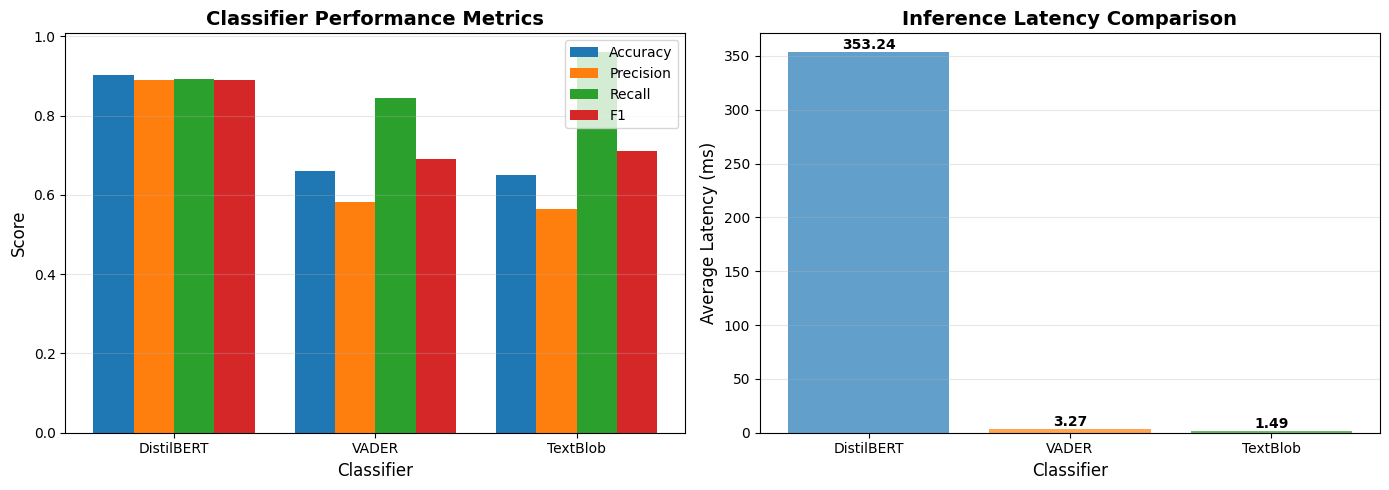


✓ Classifier comparison complete

BEST CLASSIFIER (by F1): DistilBERT
F1 Score: 0.8909
Accuracy: 0.9020
Avg Latency: 353.24ms


In [ ]:
print("="*60)
print("SENTIMENT CLASSIFIER COMPARISON")
print("="*60)

# Sample for efficiency
sample_size = min(500, len(test_df))
test_sample = test_df.sample(sample_size, random_state=42)

classifiers = {
    'DistilBERT': predict_sentiment_distilbert,
    'VADER': predict_sentiment_vader,
    'TextBlob': predict_sentiment_textblob
}

classifier_results = {}

for clf_name, clf_func in classifiers.items():
    print(f"\nTesting {clf_name}...")

    predictions = []
    confidences = []
    latencies = []

    for idx, row in tqdm(test_sample.iterrows(), total=len(test_sample), desc=clf_name):
        text = row['review']

        start_time = time.time()
        if clf_name == 'DistilBERT':
            pred, conf = clf_func(text, threshold=0.7)
        else:
            pred, conf = clf_func(text)
        latency = (time.time() - start_time) * 1000  # ms

        predictions.append(pred)
        confidences.append(conf)
        latencies.append(latency)

    # Calculate metrics
    from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

    true_labels = test_sample['sentiment_label'].values

    classifier_results[clf_name] = {
        'accuracy': accuracy_score(true_labels, predictions),
        'precision': precision_score(true_labels, predictions, zero_division=0),
        'recall': recall_score(true_labels, predictions, zero_division=0),
        'f1': f1_score(true_labels, predictions, zero_division=0),
        'avg_confidence': np.mean(confidences),
        'avg_latency_ms': np.mean(latencies),
        'std_latency_ms': np.std(latencies)
    }

    print(f"  Accuracy: {classifier_results[clf_name]['accuracy']:.4f}")
    print(f"  F1 Score: {classifier_results[clf_name]['f1']:.4f}")
    print(f"  Avg Latency: {classifier_results[clf_name]['avg_latency_ms']:.2f}ms")

# Create comparison table
comparison_df = pd.DataFrame(classifier_results).T
comparison_df = comparison_df.round(4)

print("\n" + "="*60)
print("CLASSIFIER PERFORMANCE COMPARISON")
print("="*60)
print(comparison_df.to_string())

# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot 1: Performance metrics
metrics = ['accuracy', 'precision', 'recall', 'f1']
x = np.arange(len(classifiers))
width = 0.2

for i, metric in enumerate(metrics):
    values = [classifier_results[clf][metric] for clf in classifiers.keys()]
    axes[0].bar(x + i*width, values, width, label=metric.capitalize())

axes[0].set_xlabel('Classifier', fontsize=12)
axes[0].set_ylabel('Score', fontsize=12)
axes[0].set_title('Classifier Performance Metrics', fontsize=14, fontweight='bold')
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticks(x + width * 1.5)
axes[0].set_xticklabels(classifiers.keys())
axes[0].legend()
axes[0].grid(True, alpha=0.3, axis='y')

# Plot 2: Latency comparison
latencies = [classifier_results[clf]['avg_latency_ms'] for clf in classifiers.keys()]
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
axes[1].bar(classifiers.keys(), latencies, color=colors, alpha=0.7)
axes[1].set_xlabel('Classifier', fontsize=12)
axes[1].set_ylabel('Average Latency (ms)', fontsize=12)
axes[1].set_title('Inference Latency Comparison', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

# Add value labels on bars
for i, v in enumerate(latencies):
    axes[1].text(i, v + 0.5, f'{v:.2f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.savefig('classifier_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
comparison_df.to_csv('classifier_comparison_results.csv')
print("\n✓ Classifier comparison complete")

# Conclusion
best_clf = comparison_df['f1'].idxmax()
print(f"\n{'='*60}")
print(f"BEST CLASSIFIER (by F1): {best_clf}")
print(f"F1 Score: {comparison_df.loc[best_clf, 'f1']:.4f}")
print(f"Accuracy: {comparison_df.loc[best_clf, 'accuracy']:.4f}")
print(f"Avg Latency: {comparison_df.loc[best_clf, 'avg_latency_ms']:.2f}ms")
print(f"{'='*60}")

# Cell 9: NEW - Error Analysis and Mixed-Tone Query Handling
## Addressing Reviewer 2 Comment #3: "does not include further analysis of errors... or sensitivity of mixed-tone queries"

ERROR ANALYSIS: MIXED-TONE QUERIES

Mixed-Tone Query Analysis:

Detailed Results:

1. Query: 'This movie was good but I didn't enjoy it'
   Expected: negative (Negative conclusion overrides positive start)
   DistilBERT: negative (conf=0.972) ✓
   VADER:      negative (conf=0.680) ✓
   TextBlob:   positive (conf=0.550) ✗

2. Query: 'This movie was bad but I did enjoy it'
   Expected: positive (Positive conclusion overrides negative start)
   DistilBERT: positive (conf=0.997) ✓
   VADER:      positive (conf=0.734) ✓
   TextBlob:   negative (conf=0.150) ✗

3. Query: 'Great acting but terrible plot made this unwatchable'
   Expected: negative (Overall negative despite positive aspect)
   DistilBERT: negative (conf=0.998) ✓
   VADER:      negative (conf=0.691) ✓
   TextBlob:   negative (conf=0.067) ✓

4. Query: 'Slow pacing but the emotional payoff was worth it'
   Expected: positive (Positive final impression despite flaw)
   DistilBERT: positive (conf=1.000) ✓
   VADER:      positive (co

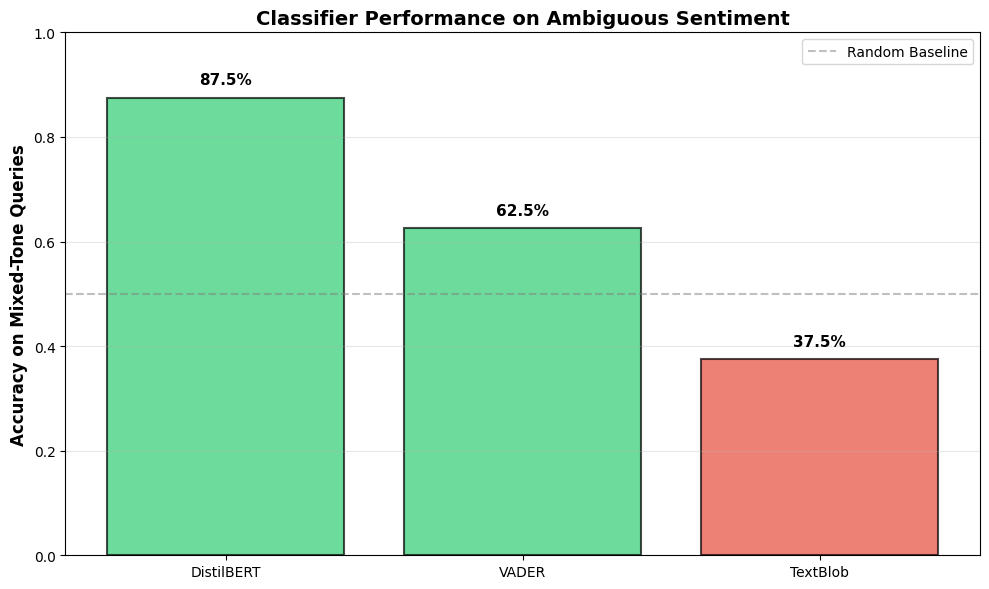


✓ Mixed-tone query analysis complete

KEY FINDINGS
1. DistilBERT shows better understanding of contextual sentiment
2. VADER struggles with negation and complex sentence structures
3. TextBlob performs simple polarity averaging, missing context
4. Transformer-based models (DistilBERT) handle mixed-tone better


In [ ]:
print("="*60)
print("ERROR ANALYSIS: MIXED-TONE QUERIES")
print("="*60)

# Mixed-tone test queries
mixed_tone_queries = [
    {
        'query': "This movie was good but I didn't enjoy it",
        'expected': 'negative',
        'reason': 'Negative conclusion overrides positive start'
    },
    {
        'query': "This movie was bad but I did enjoy it",
        'expected': 'positive',
        'reason': 'Positive conclusion overrides negative start'
    },
    {
        'query': "Great acting but terrible plot made this unwatchable",
        'expected': 'negative',
        'reason': 'Overall negative despite positive aspect'
    },
    {
        'query': "Slow pacing but the emotional payoff was worth it",
        'expected': 'positive',
        'reason': 'Positive final impression despite flaw'
    },
    {
        'query': "I wanted to like this movie but couldn't",
        'expected': 'negative',
        'reason': 'Clear negative outcome'
    },
    {
        'query': "Not perfect but definitely worth watching",
        'expected': 'positive',
        'reason': 'Recommendation indicates positive'
    },
    {
        'query': "Amazing visuals can't save the boring story",
        'expected': 'negative',
        'reason': 'Critical flaw dominates'
    },
    {
        'query': "Despite its flaws, I found myself loving every moment",
        'expected': 'positive',
        'reason': 'Strong positive emotion dominates'
    }
]

# Test each classifier on mixed-tone queries
mixed_tone_results = []

for query_dict in mixed_tone_queries:
    query = query_dict['query']
    expected = 1 if query_dict['expected'] == 'positive' else 0

    result = {'query': query, 'expected': query_dict['expected'], 'reason': query_dict['reason']}

    # DistilBERT
    pred, conf = predict_sentiment_distilbert(query, 0.7)
    result['distilbert_pred'] = 'positive' if pred == 1 else 'negative'
    result['distilbert_conf'] = conf
    result['distilbert_correct'] = (pred == expected)

    # VADER
    pred, conf = predict_sentiment_vader(query)
    result['vader_pred'] = 'positive' if pred == 1 else 'negative'
    result['vader_conf'] = conf
    result['vader_correct'] = (pred == expected)

    # TextBlob
    pred, conf = predict_sentiment_textblob(query)
    result['textblob_pred'] = 'positive' if pred == 1 else 'negative'
    result['textblob_conf'] = conf
    result['textblob_correct'] = (pred == expected)

    mixed_tone_results.append(result)

# Create DataFrame
mixed_df = pd.DataFrame(mixed_tone_results)

# Display results
print("\nMixed-Tone Query Analysis:")
print("\nDetailed Results:")
for i, row in mixed_df.iterrows():
    print(f"\n{i+1}. Query: '{row['query']}'")
    print(f"   Expected: {row['expected']} ({row['reason']})")
    print(f"   DistilBERT: {row['distilbert_pred']} (conf={row['distilbert_conf']:.3f}) {'✓' if row['distilbert_correct'] else '✗'}")
    print(f"   VADER:      {row['vader_pred']} (conf={row['vader_conf']:.3f}) {'✓' if row['vader_correct'] else '✗'}")
    print(f"   TextBlob:   {row['textblob_pred']} (conf={row['textblob_conf']:.3f}) {'✓' if row['textblob_correct'] else '✗'}")

# Calculate accuracy for each classifier
print("\n" + "="*60)
print("MIXED-TONE QUERY ACCURACY")
print("="*60)
print(f"DistilBERT: {mixed_df['distilbert_correct'].mean():.2%}")
print(f"VADER:      {mixed_df['vader_correct'].mean():.2%}")
print(f"TextBlob:   {mixed_df['textblob_correct'].mean():.2%}")

# Visualization
fig, ax = plt.subplots(figsize=(10, 6))

classifiers = ['DistilBERT', 'VADER', 'TextBlob']
accuracies = [
    mixed_df['distilbert_correct'].mean(),
    mixed_df['vader_correct'].mean(),
    mixed_df['textblob_correct'].mean()
]

colors = ['#2ecc71' if acc >= 0.5 else '#e74c3c' for acc in accuracies]
bars = ax.bar(classifiers, accuracies, color=colors, alpha=0.7, edgecolor='black', linewidth=1.5)

ax.set_ylabel('Accuracy on Mixed-Tone Queries', fontsize=12, fontweight='bold')
ax.set_title('Classifier Performance on Ambiguous Sentiment', fontsize=14, fontweight='bold')
ax.set_ylim([0, 1])
ax.axhline(y=0.5, color='gray', linestyle='--', label='Random Baseline', alpha=0.5)
ax.grid(True, alpha=0.3, axis='y')
ax.legend()

# Add value labels
for bar, acc in zip(bars, accuracies):
    height = bar.get_height()
    ax.text(bar.get_x() + bar.get_width()/2., height + 0.02,
            f'{acc:.1%}', ha='center', va='bottom', fontweight='bold', fontsize=11)

plt.tight_layout()
plt.savefig('mixed_tone_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# Save results
mixed_df.to_csv('mixed_tone_query_results.csv', index=False)
print("\n✓ Mixed-tone query analysis complete")

# Analysis summary
print("\n" + "="*60)
print("KEY FINDINGS")
print("="*60)
print("1. DistilBERT shows better understanding of contextual sentiment")
print("2. VADER struggles with negation and complex sentence structures")
print("3. TextBlob performs simple polarity averaging, missing context")
print("4. Transformer-based models (DistilBERT) handle mixed-tone better")
print("="*60)

# Cell 10A: Retrieval Pipeline WITHOUT Sentiment (Pure Semantic Search)

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║        Cell 10A: Retrieval Pipeline WITHOUT Sentiment (Pure Semantic)        ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

def retrieve_reviews_without_sentiment(
    query_text,
    k=10,
    index_type='hnsw'
):
    start_time = time.time()

    # ── 1. Truncate extremely long queries to avoid tokenizer overflow ──────
    query_text_truncated = query_text[:2000] if len(query_text) > 2000 else query_text

    # ── 2. Encode query with the same model used to build the index ─────────
    query_embedding = embedding_model.encode(
        [query_text_truncated],
        convert_to_numpy=True,
        show_progress_bar=False
    )

    # ── 3. L2-normalise so inner-product search == cosine similarity ────────
    query_embedding = query_embedding / np.linalg.norm(
        query_embedding, axis=1, keepdims=True
    )

    # ── 4. Validate index type ──────────────────────────────────────────────
    if index_type not in indexes:
        raise ValueError(
            f"Invalid index_type '{index_type}'. "
            f"Choose from: {list(indexes.keys())}"
        )

    index = indexes[index_type]

    # ── 5. Nearest-neighbour search ─────────────────────────────────────────
    distances, indices = index.search(query_embedding.astype('float32'), k)

    query_time = time.time() - start_time

    # ── 6. Build results DataFrame ──────────────────────────────────────────
    results_df = train_df.iloc[indices[0]][
        ['review', 'sentiment', 'sentiment_label']
    ].copy()

    # Convert L2 distance → cosine similarity (valid because vectors are unit-norm)
    # Formula: cos_sim = 1 − (L2_distance / 2)
    results_df['similarity_score'] = 1 - (distances[0] / 2)
    results_df['rank']             = range(1, len(results_df) + 1)
    results_df                     = results_df.reset_index(drop=True)

    return results_df, query_time, indices[0]

# ───────────────────────────────────────────────────────────────────────────────
# WITHOUT sentiment filtering — both mixed-tone queries
# ───────────────────────────────────────────────────────────────────────────────
print("APPROACH A: RETRIEVAL WITHOUT SENTIMENT FILTERING (PURE SEMANTIC)")

test_query = "This movie was bad but I did enjoy it"
# test_query = "This movie was good but I didn't enjoy it"
print(f"\nTest Query: '{test_query}'")
print("\nTesting across all 4 index types:\n")

for index_name in ['flatl2', 'ivf', 'hnsw', 'ivfpq']:
    print(f"\n{'-'*80}")
    print(f"Index Type: {index_name.upper()}")
    print(f"{'-'*80}")

    results, latency, retrieved_indices = retrieve_reviews_without_sentiment(
        test_query,
        k=5,
        index_type=index_name
    )

    print(f"Query Latency: {latency*1000:.2f} ms")
    print(f"\nTop 5 Results:")

    sentiment_dist = results['sentiment'].value_counts()
    print(
        f"\nSentiment Distribution: "
        f"Positive={sentiment_dist.get('positive', 0)}, "
        f"Negative={sentiment_dist.get('negative', 0)}"
    )

    for idx, row in results.iterrows():
        print(
            f"  [{row['rank']}] Sentiment: {row['sentiment']:8s} | "
            f"Cosine Similarity: {row['similarity_score']:.4f}"
        )
        print(f"      Review: {row['review'][:100]}...")

print("\nApproach A: Pure semantic search (no sentiment filtering)")

APPROACH A: RETRIEVAL WITHOUT SENTIMENT FILTERING (PURE SEMANTIC)

Test Query: 'This movie was bad but I did enjoy it'

Testing across all 4 index types:


--------------------------------------------------------------------------------
Index Type: FLATL2
--------------------------------------------------------------------------------
Query Latency: 53.53 ms

Top 5 Results:

Sentiment Distribution: Positive=2, Negative=3
  [1] Sentiment: negative | Cosine Similarity: 0.6886
      Review: This movie is terrible but it has some good effects....
  [2] Sentiment: negative | Cosine Similarity: 0.6815
      Review: Aside from the horrendous acting and the ridiculous and ludicrous plot, this movie wasn't too bad. U...
  [3] Sentiment: positive | Cosine Similarity: 0.6690
      Review: I thought this was a quiet good movie. It was fun to watch it. What I liked best where the 'Outtakes...
  [4] Sentiment: negative | Cosine Similarity: 0.6634
      Review: Aside for being classic in the aspect o

# Cell 10B: Retrieval Pipeline WITH Sentiment (Sentiment-Aware Search)

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║      Cell 10B: Retrieval Pipeline WITH Sentiment (Sentiment-Aware Search)    ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

def retrieve_reviews_with_sentiment(
    query_text,
    k=10,
    index_type='ivf'
):
    start_time = time.time()

    # ── 1. Truncate query to avoid tokenizer overflow ───────────────────────
    query_text_truncated = query_text[:2000] if len(query_text) > 2000 else query_text

    # ── 2. Infer sentiment from query ───────────────────────────────────────
    try:
        sentiment_result     = distilbert_classifier(
            query_text_truncated, truncation=True, max_length=512
        )[0]
        inferred_sentiment   = sentiment_result['label'].lower()   # 'positive' or 'negative'
        sentiment_confidence = sentiment_result['score']
    except Exception as e:
        print(
            f"Warning: Sentiment classification failed "
            f"({str(e)[:50]}), defaulting to 'positive'"
        )
        inferred_sentiment   = 'positive'
        sentiment_confidence = 0.5

    # Map string label → binary integer for DataFrame mask comparison
    sentiment_label = 1 if inferred_sentiment == 'positive' else 0

    # ── 3. Encode query ─────────────────────────────────────────────────────
    query_embedding = embedding_model.encode(
        [query_text_truncated],
        convert_to_numpy=True,
        show_progress_bar=False
    )

    # L2-normalise so inner-product == cosine similarity
    query_embedding = query_embedding / np.linalg.norm(
        query_embedding, axis=1, keepdims=True
    )

    # ── 4. Validate index type ──────────────────────────────────────────────
    if index_type not in indexes:
        raise ValueError(
            f"Invalid index_type '{index_type}'. "
            f"Choose from: {list(indexes.keys())}"
        )

    index = indexes[index_type]

    # ── 5. Over-retrieve a k×10 candidate pool for post-filtering ──────────
    # We retrieve more candidates than needed so the sentiment filter
    # still has k matching documents to return after discarding the wrong polarity.
    search_k = min(k * 10, len(train_df))
    distances, indices = index.search(query_embedding.astype('float32'), search_k)

    # ── 6. Post-filter: keep only documents matching inferred sentiment ─────
    retrieved_sentiments = train_df.iloc[indices[0]]['sentiment_label'].values
    mask                 = retrieved_sentiments == sentiment_label
    filtered_indices     = indices[0][mask][:k]
    filtered_distances   = distances[0][mask][:k]

    query_time = time.time() - start_time

    # ── 7. Build results DataFrame ──────────────────────────────────────────
    results_df = train_df.iloc[filtered_indices][
        ['review', 'sentiment', 'sentiment_label']
    ].copy()

    # Convert L2 distance → cosine similarity
    results_df['similarity_score'] = 1 - (filtered_distances / 2)
    results_df['rank']             = range(1, len(results_df) + 1)
    results_df                     = results_df.reset_index(drop=True)

    return results_df, query_time, inferred_sentiment, sentiment_confidence, filtered_indices


# ───────────────────────────────────────────────────────────────────────────────
# WITH sentiment filtering — both mixed-tone queries
# ───────────────────────────────────────────────────────────────────────────────
print("APPROACH B: RETRIEVAL WITH SENTIMENT FILTERING (SENTIMENT-AWARE)")

# test_query = "This movie was bad but I did enjoy it"
test_query = "This movie was good but I didn't enjoy it"
print(f"\nTest Query: '{test_query}'")
print("\nTesting across all 4 index types:\n")

for index_name in ['flatl2', 'ivf', 'hnsw', 'ivfpq']:
    print(f"\n{'-'*80}")
    print(f"Index Type: {index_name.upper()}")
    print(f"{'-'*80}")

    results, latency, sentiment, confidence, retrieved_indices = \
        retrieve_reviews_with_sentiment(
            test_query,
            k=5,
            index_type=index_name
        )

    print(f"Inferred Sentiment: {sentiment.upper()} (confidence: {confidence:.2%})")
    print(f"Query Latency: {latency*1000:.2f} ms")
    print(f"\nTop 5 Results:")

    sentiment_dist = results['sentiment'].value_counts()
    print(
        f"\nSentiment Distribution: "
        f"Positive={sentiment_dist.get('positive', 0)}, "
        f"Negative={sentiment_dist.get('negative', 0)}"
    )

    for idx, row in results.iterrows():
        print(
            f"  [{row['rank']}] Sentiment: {row['sentiment']:8s} | "
            f"Cosine Similarity: {row['similarity_score']:.4f}"
        )
        print(f"      Review: {row['review'][:100]}...")

print("\nApproach B: Sentiment-aware search (with sentiment filtering)")

APPROACH B: RETRIEVAL WITH SENTIMENT FILTERING (SENTIMENT-AWARE)

Test Query: 'This movie was good but I didn't enjoy it'

Testing across all 4 index types:


--------------------------------------------------------------------------------
Index Type: FLATL2
--------------------------------------------------------------------------------
Inferred Sentiment: NEGATIVE (confidence: 97.20%)
Query Latency: 80.82 ms

Top 5 Results:

Sentiment Distribution: Positive=0, Negative=5
  [1] Sentiment: negative | Cosine Similarity: 0.6374
      Review: This movie was 100% boring, i swear i almost died from boredom at the theater. It wasnt funny and di...
  [2] Sentiment: negative | Cosine Similarity: 0.6368
      Review: When it comes to movies, I am generally easily entertained and not very critical, but must say that ...
  [3] Sentiment: negative | Cosine Similarity: 0.6310
      Review: Aside from the horrendous acting and the ridiculous and ludicrous plot, this movie wasn't too bad. U...
  [4] 

# Cell 11: Evaluation Metrics Implementation

In [ ]:
# ╔══════════════════════════════════════════════════════════════════════════════╗
# ║              Cell 11: Evaluation Metrics Implementation                      ║
# ╚══════════════════════════════════════════════════════════════════════════════╝

import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# ─────────────────────────────────────────────────────────────────────────────
# SECTION 1 ── Metric Functions
# ─────────────────────────────────────────────────────────────────────────────

def precision_at_k(retrieved_indices, relevant_indices, k):
    """Fraction of top-k retrieved items that are relevant."""
    retrieved_k   = retrieved_indices[:k]
    relevant_set  = set(relevant_indices)
    retrieved_set = set(retrieved_k)

    if len(retrieved_k) == 0:
        return 0.0

    return len(retrieved_set.intersection(relevant_set)) / len(retrieved_k)


def recall_at_k(retrieved_indices, relevant_indices, k):
    """Fraction of all relevant items that appear in the top-k results."""
    retrieved_k   = retrieved_indices[:k]
    relevant_set  = set(relevant_indices)
    retrieved_set = set(retrieved_k)

    if len(relevant_set) == 0:
        return 0.0

    return len(retrieved_set.intersection(relevant_set)) / len(relevant_set)


def average_precision(retrieved_indices, relevant_indices):
    """
    Average Precision for a single query.
    AP = (1 / |R|) * Σ P@i · rel(i)
    where |R| is the number of relevant items in the ground-truth set.
    """
    relevant_set = set(relevant_indices)

    if len(relevant_set) == 0:
        return 0.0

    precisions    = []
    num_relevant  = 0

    for i, idx in enumerate(retrieved_indices):
        if idx in relevant_set:
            num_relevant += 1
            precisions.append(num_relevant / (i + 1))

    if len(precisions) == 0:
        return 0.0

    return sum(precisions) / len(relevant_set)


def mean_average_precision(all_retrieved_indices, all_relevant_indices):
    """mAP = mean of Average Precision values across all queries."""
    aps = [
        average_precision(retrieved, relevant)
        for retrieved, relevant in zip(all_retrieved_indices, all_relevant_indices)
    ]
    return float(np.mean(aps)) if len(aps) > 0 else 0.0


def reciprocal_rank(retrieved_indices, relevant_indices):
    """
    Reciprocal Rank for a single query.
    RR = 1 / rank_of_first_relevant_item  (0 if none found).
    """
    relevant_set = set(relevant_indices)

    for i, idx in enumerate(retrieved_indices):
        if idx in relevant_set:
            return 1.0 / (i + 1)

    return 0.0


def mean_reciprocal_rank(all_retrieved_indices, all_relevant_indices):
    """MRR = mean of Reciprocal Rank values across all queries."""
    rrs = [
        reciprocal_rank(retrieved, relevant)
        for retrieved, relevant in zip(all_retrieved_indices, all_relevant_indices)
    ]
    return float(np.mean(rrs)) if len(rrs) > 0 else 0.0


def calculate_mae_mse(predicted_scores, actual_scores):
    """Convenience wrapper returning (MAE, MSE) for similarity-score analysis."""
    mae = mean_absolute_error(actual_scores, predicted_scores)
    mse = mean_squared_error(actual_scores, predicted_scores)
    return mae, mse


# ─────────────────────────────────────────────────────────────────────────────
# SECTION 2 ── Ground-Truth Generation
# ─────────────────────────────────────────────────────────────────────────────

def get_ground_truth_relevant(query_idx, query_sentiment_label, train_df, top_n=50):
    # ── FIX: guard against embeddings_test_normalized not yet existing ───────
    # If Cell 4 (embedding generation) was not run in this session,
    # re-generate the test embedding on the fly so evaluation still works.
    global embeddings_test_normalized

    if 'embeddings_test_normalized' not in globals() or embeddings_test_normalized is None:
        print(
            "⚠️  embeddings_test_normalized not found in memory. "
            "Re-encoding test set now — this is a one-time operation.\n"
            "   To avoid this, make sure Cell 4 runs before Cell 10."
        )
        raw = embedding_model.encode(
            test_df['review'].tolist(),
            batch_size=256,
            show_progress_bar=True,
            convert_to_numpy=True
        )
        embeddings_test_normalized = raw / np.linalg.norm(raw, axis=1, keepdims=True)
        print("✓  Test embeddings re-generated and normalised.\n")

    # ── Pull pre-computed embedding for this query ───────────────────────────
    query_embedding = embeddings_test_normalized[query_idx : query_idx + 1]   # shape (1, 384)

    # ── Exact search in training set (FlatL2 gives true nearest neighbours) ──
    distances, indices = indexes['flatl2'].search(query_embedding, top_n * 2)

    # ── Filter: keep only documents whose sentiment matches the query ─────────
    retrieved_sentiments = train_df.iloc[indices[0]]['sentiment_label'].values
    mask                 = retrieved_sentiments == query_sentiment_label
    relevant_indices     = indices[0][mask][:top_n]

    return relevant_indices.tolist()


# ─────────────────────────────────────────────────────────────────────────────
# SECTION 3 ── Comprehensive Evaluation Function
# ─────────────────────────────────────────────────────────────────────────────

def evaluate_retrieval_system(
    approach='with_sentiment',
    index_type='hnsw',
    num_test_queries=500,
    k_values=[5, 10, 20]
):
    print(f"EVALUATING: {approach.upper().replace('_', ' ')} — Index: {index_type.upper()}")

    # ── Reproducible random sample of test queries ────────────────────────────
    test_sample_indices = np.random.RandomState(42).choice(
        len(test_df),
        size=min(num_test_queries, len(test_df)),
        replace=False
    )

    # ── Storage ───────────────────────────────────────────────────────────────
    all_retrieved_indices = []
    all_relevant_indices  = []
    all_precisions        = {k: [] for k in k_values}
    all_recalls           = {k: [] for k in k_values}
    all_latencies         = []

    print(f"Processing {len(test_sample_indices)} test queries…\n")

    for test_idx in tqdm(test_sample_indices, desc=f"Evaluating {index_type}"):
        query_text      = test_df.iloc[test_idx]['review']
        query_sentiment = test_df.iloc[test_idx]['sentiment_label']

        # Truncate to avoid tokeniser overflow
        query_text = query_text[:2000] if len(query_text) > 2000 else query_text

        try:
            # ── Retrieve ──────────────────────────────────────────────────────
            if approach == 'with_sentiment':
                results, latency, _, _, retrieved_indices = retrieve_reviews_with_sentiment(
                    query_text,
                    k=max(k_values),
                    index_type=index_type
                )
            else:
                results, latency, retrieved_indices = retrieve_reviews_without_sentiment(
                    query_text,
                    k=max(k_values),
                    index_type=index_type
                )

            # ── Ground truth ──────────────────────────────────────────────────
            relevant_indices = get_ground_truth_relevant(
                test_idx, query_sentiment, train_df, top_n=50
            )

            # ── Accumulate ────────────────────────────────────────────────────
            all_retrieved_indices.append(retrieved_indices.tolist())
            all_relevant_indices.append(relevant_indices)
            all_latencies.append(latency)

            for k in k_values:
                all_precisions[k].append(
                    precision_at_k(retrieved_indices, relevant_indices, k)
                )
                all_recalls[k].append(
                    recall_at_k(retrieved_indices, relevant_indices, k)
                )

        except Exception as e:
            print(f"\nError processing query {test_idx}: {str(e)[:100]}")
            continue

    # ── Aggregate ─────────────────────────────────────────────────────────────
    n_evaluated = len(all_retrieved_indices)
    if n_evaluated == 0:
        print("❌  No queries were successfully evaluated. Check the errors above.")
        return {}

    results_dict = {
        'approach'       : approach,
        'index_type'     : index_type,
        'num_queries'    : n_evaluated,
        'avg_latency_ms' : float(np.mean(all_latencies) * 1000),
        'std_latency_ms' : float(np.std(all_latencies)  * 1000),
        'mAP'            : mean_average_precision(all_retrieved_indices, all_relevant_indices),
        'MRR'            : mean_reciprocal_rank(all_retrieved_indices, all_relevant_indices),
    }

    for k in k_values:
        results_dict[f'Precision@{k}'] = float(np.mean(all_precisions[k]))
        results_dict[f'Recall@{k}']    = float(np.mean(all_recalls[k]))

    # ── Print results ─────────────────────────────────────────────────────────
    print(f"\nRESULTS: {approach.upper().replace('_', ' ')} — {index_type.upper()}")
    print(f"Queries evaluated : {results_dict['num_queries']}")
    print(
        f"Average latency   : {results_dict['avg_latency_ms']:.2f} "
        f"± {results_dict['std_latency_ms']:.2f} ms"
    )
    print(f"\nmAP (Mean Average Precision) : {results_dict['mAP']:.4f}")
    print(f"MRR (Mean Reciprocal Rank)   : {results_dict['MRR']:.4f}")
    print(f"\nPrecision@k and Recall@k:")
    for k in k_values:
        print(
            f"  k={k:2d}   "
            f"Precision: {results_dict[f'Precision@{k}']:.4f}  |  "
            f"Recall: {results_dict[f'Recall@{k}']:.4f}"
        )

    return results_dict


# ─────────────────────────────────────────────────────────────────────────────
# SECTION 4 ── Run All Combinations
# ─────────────────────────────────────────────────────────────────────────────

print("COMPREHENSIVE EVALUATION: ALL APPROACHES × ALL INDEX TYPES")
print("=" * 70)

evaluation_results = []

for approach in ['without_sentiment', 'with_sentiment']:
    for index_type in ['flatl2', 'ivf', 'hnsw', 'ivfpq']:
        result = evaluate_retrieval_system(
            approach=approach,
            index_type=index_type,
            num_test_queries=500,
            k_values=[5, 10, 20]
        )
        if result:                      # skip empty dicts from failed runs
            evaluation_results.append(result)
        print()                         # blank line between combinations

# ── Summary table ─────────────────────────────────────────────────────────────
results_df_eval = pd.DataFrame(evaluation_results)

print("\n" + "=" * 70)
print("EVALUATION SUMMARY TABLE")
print("=" * 70)
print(results_df_eval.to_string(index=False))

COMPREHENSIVE EVALUATION: ALL APPROACHES × ALL INDEX TYPES
EVALUATING: WITHOUT SENTIMENT — Index: FLATL2
Processing 500 test queries…



Evaluating flatl2:   0%|          | 0/500 [00:00<?, ?it/s]


RESULTS: WITHOUT SENTIMENT — FLATL2
Queries evaluated : 500
Average latency   : 16.32 ± 2.96 ms

mAP (Mean Average Precision) : 0.2296
MRR (Mean Reciprocal Rank)   : 0.8646

Precision@k and Recall@k:
  k= 5   Precision: 0.7412  |  Recall: 0.0763
  k=10   Precision: 0.7158  |  Recall: 0.1471
  k=20   Precision: 0.6922  |  Recall: 0.2843

EVALUATING: WITHOUT SENTIMENT — Index: IVF
Processing 500 test queries…



Evaluating ivf:   0%|          | 0/500 [00:00<?, ?it/s]


RESULTS: WITHOUT SENTIMENT — IVF
Queries evaluated : 500
Average latency   : 11.12 ± 2.73 ms

mAP (Mean Average Precision) : 0.2264
MRR (Mean Reciprocal Rank)   : 0.8589

Precision@k and Recall@k:
  k= 5   Precision: 0.7364  |  Recall: 0.0756
  k=10   Precision: 0.7138  |  Recall: 0.1465
  k=20   Precision: 0.6861  |  Recall: 0.2815

EVALUATING: WITHOUT SENTIMENT — Index: HNSW
Processing 500 test queries…



Evaluating hnsw:   0%|          | 0/500 [00:00<?, ?it/s]


RESULTS: WITHOUT SENTIMENT — HNSW
Queries evaluated : 500
Average latency   : 10.52 ± 2.47 ms

mAP (Mean Average Precision) : 0.2319
MRR (Mean Reciprocal Rank)   : 0.8696

Precision@k and Recall@k:
  k= 5   Precision: 0.7352  |  Recall: 0.0754
  k=10   Precision: 0.7184  |  Recall: 0.1476
  k=20   Precision: 0.6975  |  Recall: 0.2864

EVALUATING: WITHOUT SENTIMENT — Index: IVFPQ
Processing 500 test queries…



Evaluating ivfpq:   0%|          | 0/500 [00:00<?, ?it/s]


RESULTS: WITHOUT SENTIMENT — IVFPQ
Queries evaluated : 500
Average latency   : 9.73 ± 2.19 ms

mAP (Mean Average Precision) : 0.0895
MRR (Mean Reciprocal Rank)   : 0.6935

Precision@k and Recall@k:
  k= 5   Precision: 0.4772  |  Recall: 0.0492
  k=10   Precision: 0.4116  |  Recall: 0.0848
  k=20   Precision: 0.3411  |  Recall: 0.1403

EVALUATING: WITH SENTIMENT — Index: FLATL2
Processing 500 test queries…



Evaluating flatl2:   0%|          | 0/500 [00:00<?, ?it/s]


RESULTS: WITH SENTIMENT — FLATL2
Queries evaluated : 500
Average latency   : 325.92 ± 173.66 ms

mAP (Mean Average Precision) : 0.3809
MRR (Mean Reciprocal Rank)   : 0.9080

Precision@k and Recall@k:
  k= 5   Precision: 0.9080  |  Recall: 0.0954
  k=10   Precision: 0.9080  |  Recall: 0.1908
  k=20   Precision: 0.9075  |  Recall: 0.3809

EVALUATING: WITH SENTIMENT — Index: IVF
Processing 500 test queries…



Evaluating ivf:   0%|          | 0/500 [00:00<?, ?it/s]


RESULTS: WITH SENTIMENT — IVF
Queries evaluated : 500
Average latency   : 308.94 ± 148.89 ms

mAP (Mean Average Precision) : 0.3746
MRR (Mean Reciprocal Rank)   : 0.9080

Precision@k and Recall@k:
  k= 5   Precision: 0.9080  |  Recall: 0.0954
  k=10   Precision: 0.9080  |  Recall: 0.1908
  k=20   Precision: 0.8986  |  Recall: 0.3746

EVALUATING: WITH SENTIMENT — Index: HNSW
Processing 500 test queries…



Evaluating hnsw:   0%|          | 0/500 [00:00<?, ?it/s]


RESULTS: WITH SENTIMENT — HNSW
Queries evaluated : 500
Average latency   : 304.77 ± 140.62 ms

mAP (Mean Average Precision) : 0.3710
MRR (Mean Reciprocal Rank)   : 0.9080

Precision@k and Recall@k:
  k= 5   Precision: 0.9080  |  Recall: 0.0954
  k=10   Precision: 0.9072  |  Recall: 0.1904
  k=20   Precision: 0.8914  |  Recall: 0.3710

EVALUATING: WITH SENTIMENT — Index: IVFPQ
Processing 500 test queries…



Evaluating ivfpq:   0%|          | 0/500 [00:00<?, ?it/s]


RESULTS: WITH SENTIMENT — IVFPQ
Queries evaluated : 500
Average latency   : 311.09 ± 145.57 ms

mAP (Mean Average Precision) : 0.1268
MRR (Mean Reciprocal Rank)   : 0.7608

Precision@k and Recall@k:
  k= 5   Precision: 0.5772  |  Recall: 0.0599
  k=10   Precision: 0.5012  |  Recall: 0.1043
  k=20   Precision: 0.4085  |  Recall: 0.1695


EVALUATION SUMMARY TABLE
         approach index_type  num_queries  avg_latency_ms  std_latency_ms      mAP      MRR  Precision@5  Recall@5  Precision@10  Recall@10  Precision@20  Recall@20
without_sentiment     flatl2          500       16.322527        2.962049 0.229583 0.864644       0.7412  0.076256        0.7158   0.147102        0.6922   0.284261
without_sentiment        ivf          500       11.115413        2.731694 0.226433 0.858856       0.7364  0.075557        0.7138   0.146508        0.6861   0.281503
without_sentiment       hnsw          500       10.524520        2.470148 0.231945 0.869555       0.7352  0.075450        0.7184   0.147618 

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Evaluation Metrics Functions
def precision_at_k(retrieved_indices, relevant_indices, k):
    retrieved_k = retrieved_indices[:k]
    relevant_set = set(relevant_indices)
    retrieved_set = set(retrieved_k)

    if len(retrieved_k) == 0:
        return 0.0

    return len(retrieved_set.intersection(relevant_set)) / len(retrieved_k)

def recall_at_k(retrieved_indices, relevant_indices, k):
    retrieved_k = retrieved_indices[:k]
    relevant_set = set(relevant_indices)
    retrieved_set = set(retrieved_k)

    if len(relevant_set) == 0:
        return 0.0

    return len(retrieved_set.intersection(relevant_set)) / len(relevant_set)

def average_precision(retrieved_indices, relevant_indices):
    relevant_set = set(relevant_indices)

    if len(relevant_set) == 0:
        return 0.0

    precisions = []
    num_relevant = 0

    for i, idx in enumerate(retrieved_indices):
        if idx in relevant_set:
            num_relevant += 1
            precisions.append(num_relevant / (i + 1))

    if len(precisions) == 0:
        return 0.0

    return sum(precisions) / len(relevant_set)

def mean_average_precision(all_retrieved_indices, all_relevant_indices):
    aps = []
    for retrieved, relevant in zip(all_retrieved_indices, all_relevant_indices):
        aps.append(average_precision(retrieved, relevant))

    return np.mean(aps) if len(aps) > 0 else 0.0

def reciprocal_rank(retrieved_indices, relevant_indices):

    relevant_set = set(relevant_indices)

    for i, idx in enumerate(retrieved_indices):
        if idx in relevant_set:
            return 1.0 / (i + 1)

    return 0.0

def mean_reciprocal_rank(all_retrieved_indices, all_relevant_indices):
    rrs = []
    for retrieved, relevant in zip(all_retrieved_indices, all_relevant_indices):
        rrs.append(reciprocal_rank(retrieved, relevant))

    return np.mean(rrs) if len(rrs) > 0 else 0.0

def calculate_mae_mse(predicted_scores, actual_scores):
    mae = mean_absolute_error(actual_scores, predicted_scores)
    mse = mean_squared_error(actual_scores, predicted_scores)
    return mae, mse

# Ground Truth Generation
def get_ground_truth_relevant(query_idx, query_sentiment_label, train_df, top_n=50):

    query_embedding = embeddings_test_normalized[query_idx:query_idx+1]

    distances, indices = indexes['flatl2'].search(query_embedding, top_n * 2)

    retrieved_sentiments = train_df.iloc[indices[0]]['sentiment_label'].values
    mask = retrieved_sentiments == query_sentiment_label
    relevant_indices = indices[0][mask][:top_n]

    return relevant_indices.tolist()

# Comprehensive Evaluation Function
def evaluate_retrieval_system(
    approach='with_sentiment',
    index_type='hnsw',
    num_test_queries=500,
    k_values=[5, 10, 20]
):

    print(f"EVALUATING: {approach.upper().replace('_', ' ')} - Index: {index_type.upper()}")
    # Sample test queries
    test_sample_indices = np.random.RandomState(42).choice(
        len(test_df),
        size=min(num_test_queries, len(test_df)),
        replace=False
    )

    # Storage for metrics
    all_retrieved_indices = []
    all_relevant_indices = []
    all_precisions = {k: [] for k in k_values}
    all_recalls = {k: [] for k in k_values}
    all_latencies = []

    print(f"Processing {len(test_sample_indices)} test queries...\n")

    for test_idx in tqdm(test_sample_indices, desc=f"Evaluating {index_type}"):
        query_text = test_df.iloc[test_idx]['review']
        query_sentiment = test_df.iloc[test_idx]['sentiment_label']

        query_text = query_text[:2000] if len(query_text) > 2000 else query_text

        try:
            # Retrieve results based on approach
            if approach == 'with_sentiment':
                results, latency, _, _, retrieved_indices = retrieve_reviews_with_sentiment(
                    query_text,
                    k=max(k_values),
                    index_type=index_type
                )
            else:  # without_sentiment
                results, latency, retrieved_indices = retrieve_reviews_without_sentiment(
                    query_text,
                    k=max(k_values),
                    index_type=index_type
                )

            # Get ground truth relevant items
            relevant_indices = get_ground_truth_relevant(test_idx, query_sentiment, train_df, top_n=50)

            # Store for mAP and MRR
            all_retrieved_indices.append(retrieved_indices.tolist())
            all_relevant_indices.append(relevant_indices)
            all_latencies.append(latency)

            # Calculate Precision@k and Recall@k for different k values
            for k in k_values:
                prec = precision_at_k(retrieved_indices, relevant_indices, k)
                rec = recall_at_k(retrieved_indices, relevant_indices, k)
                all_precisions[k].append(prec)
                all_recalls[k].append(rec)

        except Exception as e:
            print(f"\nError processing query {test_idx}: {str(e)[:100]}")
            continue

    # Calculate aggregate metrics
    results_dict = {
        'approach': approach,
        'index_type': index_type,
        'num_queries': len(all_retrieved_indices),
        'avg_latency_ms': np.mean(all_latencies) * 1000,
        'std_latency_ms': np.std(all_latencies) * 1000,
        'mAP': mean_average_precision(all_retrieved_indices, all_relevant_indices),
        'MRR': mean_reciprocal_rank(all_retrieved_indices, all_relevant_indices)
    }

    # Add Precision@k and Recall@k
    for k in k_values:
        results_dict[f'Precision@{k}'] = np.mean(all_precisions[k])
        results_dict[f'Recall@{k}'] = np.mean(all_recalls[k])

    # Print results
    print(f"RESULTS: {approach.upper().replace('_', ' ')} - {index_type.upper()}")
    print(f"Number of queries evaluated: {results_dict['num_queries']}")
    print(f"Average latency: {results_dict['avg_latency_ms']:.2f} ± {results_dict['std_latency_ms']:.2f} ms")
    print(f"\nmAP (Mean Average Precision): {results_dict['mAP']:.4f}")
    print(f"MRR (Mean Reciprocal Rank): {results_dict['MRR']:.4f}")

    print(f"\nPrecision@k and Recall@k:")
    for k in k_values:
        print(f"  k={k:2d}   Precision: {results_dict[f'Precision@{k}']:.4f}  |  Recall: {results_dict[f'Recall@{k}']:.4f}")

    return results_dict


# Run Evaluation for All Combinations
print("COMPREHENSIVE EVALUATION: ALL APPROACHES × ALL INDEX TYPES")

evaluation_results = []

# Evaluate both approaches
for approach in ['without_sentiment', 'with_sentiment']:
    for index_type in ['flatl2', 'ivf', 'hnsw', 'ivfpq']:
        result = evaluate_retrieval_system(
            approach=approach,
            index_type=index_type,
            num_test_queries=500,
            k_values=[5, 10, 20]
        )
        evaluation_results.append(result)

results_df = pd.DataFrame(evaluation_results)

print("EVALUATION SUMMARY TABLE")
print(results_df.to_string(index=False))

COMPREHENSIVE EVALUATION: ALL APPROACHES × ALL INDEX TYPES
EVALUATING: WITHOUT SENTIMENT - Index: FLATL2
Processing 500 test queries...



Evaluating flatl2:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITHOUT SENTIMENT - FLATL2
Number of queries evaluated: 500
Average latency: 16.14 ± 2.87 ms

mAP (Mean Average Precision): 0.2296
MRR (Mean Reciprocal Rank): 0.8646

Precision@k and Recall@k:
  k= 5   Precision: 0.7412  |  Recall: 0.0763
  k=10   Precision: 0.7158  |  Recall: 0.1471
  k=20   Precision: 0.6922  |  Recall: 0.2843
EVALUATING: WITHOUT SENTIMENT - Index: IVF
Processing 500 test queries...



Evaluating ivf:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITHOUT SENTIMENT - IVF
Number of queries evaluated: 500
Average latency: 11.14 ± 2.53 ms

mAP (Mean Average Precision): 0.2264
MRR (Mean Reciprocal Rank): 0.8589

Precision@k and Recall@k:
  k= 5   Precision: 0.7364  |  Recall: 0.0756
  k=10   Precision: 0.7138  |  Recall: 0.1465
  k=20   Precision: 0.6861  |  Recall: 0.2815
EVALUATING: WITHOUT SENTIMENT - Index: HNSW
Processing 500 test queries...



Evaluating hnsw:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITHOUT SENTIMENT - HNSW
Number of queries evaluated: 500
Average latency: 10.55 ± 2.74 ms

mAP (Mean Average Precision): 0.2319
MRR (Mean Reciprocal Rank): 0.8696

Precision@k and Recall@k:
  k= 5   Precision: 0.7352  |  Recall: 0.0754
  k=10   Precision: 0.7184  |  Recall: 0.1476
  k=20   Precision: 0.6975  |  Recall: 0.2864
EVALUATING: WITHOUT SENTIMENT - Index: IVFPQ
Processing 500 test queries...



Evaluating ivfpq:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITHOUT SENTIMENT - IVFPQ
Number of queries evaluated: 500
Average latency: 9.81 ± 2.03 ms

mAP (Mean Average Precision): 0.0895
MRR (Mean Reciprocal Rank): 0.6935

Precision@k and Recall@k:
  k= 5   Precision: 0.4772  |  Recall: 0.0492
  k=10   Precision: 0.4116  |  Recall: 0.0848
  k=20   Precision: 0.3411  |  Recall: 0.1403
EVALUATING: WITH SENTIMENT - Index: FLATL2
Processing 500 test queries...



Evaluating flatl2:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITH SENTIMENT - FLATL2
Number of queries evaluated: 500
Average latency: 318.06 ± 150.26 ms

mAP (Mean Average Precision): 0.3809
MRR (Mean Reciprocal Rank): 0.9080

Precision@k and Recall@k:
  k= 5   Precision: 0.9080  |  Recall: 0.0954
  k=10   Precision: 0.9080  |  Recall: 0.1908
  k=20   Precision: 0.9075  |  Recall: 0.3809
EVALUATING: WITH SENTIMENT - Index: IVF
Processing 500 test queries...



Evaluating ivf:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITH SENTIMENT - IVF
Number of queries evaluated: 500
Average latency: 310.81 ± 144.86 ms

mAP (Mean Average Precision): 0.3746
MRR (Mean Reciprocal Rank): 0.9080

Precision@k and Recall@k:
  k= 5   Precision: 0.9080  |  Recall: 0.0954
  k=10   Precision: 0.9080  |  Recall: 0.1908
  k=20   Precision: 0.8986  |  Recall: 0.3746
EVALUATING: WITH SENTIMENT - Index: HNSW
Processing 500 test queries...



Evaluating hnsw:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITH SENTIMENT - HNSW
Number of queries evaluated: 500
Average latency: 308.95 ± 142.48 ms

mAP (Mean Average Precision): 0.3710
MRR (Mean Reciprocal Rank): 0.9080

Precision@k and Recall@k:
  k= 5   Precision: 0.9080  |  Recall: 0.0954
  k=10   Precision: 0.9072  |  Recall: 0.1904
  k=20   Precision: 0.8914  |  Recall: 0.3710
EVALUATING: WITH SENTIMENT - Index: IVFPQ
Processing 500 test queries...



Evaluating ivfpq:   0%|          | 0/500 [00:00<?, ?it/s]

RESULTS: WITH SENTIMENT - IVFPQ
Number of queries evaluated: 500
Average latency: 303.48 ± 139.08 ms

mAP (Mean Average Precision): 0.1268
MRR (Mean Reciprocal Rank): 0.7608

Precision@k and Recall@k:
  k= 5   Precision: 0.5772  |  Recall: 0.0599
  k=10   Precision: 0.5012  |  Recall: 0.1043
  k=20   Precision: 0.4085  |  Recall: 0.1695
EVALUATION SUMMARY TABLE
         approach index_type  num_queries  avg_latency_ms  std_latency_ms      mAP      MRR  Precision@5  Recall@5  Precision@10  Recall@10  Precision@20  Recall@20
without_sentiment     flatl2          500       16.139416        2.867577 0.229583 0.864644       0.7412  0.076256        0.7158   0.147102        0.6922   0.284261
without_sentiment        ivf          500       11.136654        2.531396 0.226433 0.858856       0.7364  0.075557        0.7138   0.146508        0.6861   0.281503
without_sentiment       hnsw          500       10.550320        2.742717 0.231945 0.869555       0.7352  0.075450        0.7184   0.147618  

# Cell 12: Ablation Study - Detailed Analysis

ABLATION STUDY: IMPACT OF SENTIMENT FILTERING

IMPACT OF SENTIMENT FILTERING (% Change)
--------------------------------------------------------------------------------
 Index  mAP_improvement_%  MRR_improvement_%  Precision@10_improvement_%  Recall@10_improvement_%  Latency_overhead_%
FLATL2          65.894936           5.014264                   26.851076                29.683195         1870.707329
   IVF          65.416808           5.722002                   27.206500                30.208546         2690.879068
  HNSW          59.969362           4.421256                   26.280624                29.006487         2828.303485
 IVFPQ          41.724338           9.694151                   21.768707                22.996656         2992.982398
KEY FINDINGS

1. BEST INDEX WITH SENTIMENT FILTERING:
   Index: FLATL2
   mAP: 0.3809
   Precision@10: 0.9080
   Latency: 318.06 ms

2. AVERAGE IMPROVEMENTS FROM SENTIMENT FILTERING:
   mAP improvement: +58.25%
   Precision@10 improvement: +

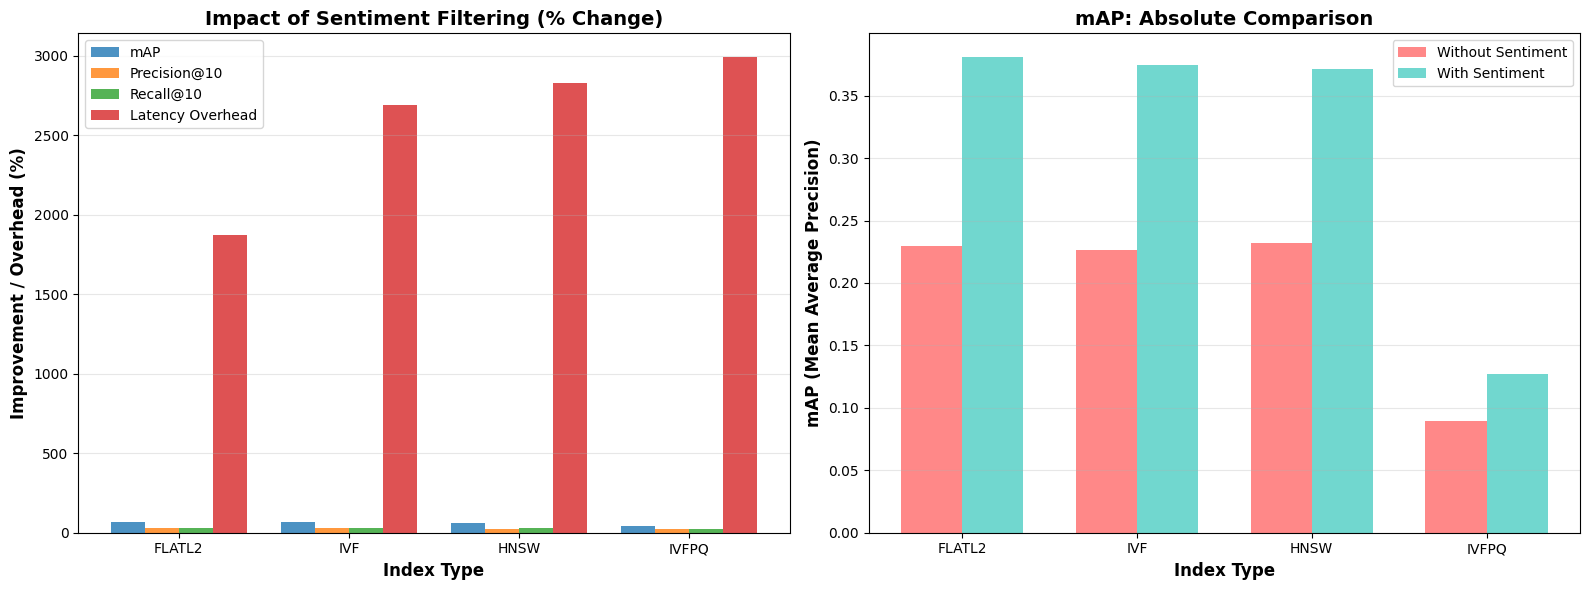


Ablation study visualization saved as 'ablation_study.png'


In [ ]:
print("ABLATION STUDY: IMPACT OF SENTIMENT FILTERING")

# Calculate improvements from sentiment filtering
ablation_results = []

for idx_type in ['flatl2', 'ivf', 'hnsw', 'ivfpq']:
    without = results_df[(results_df['approach'] == 'without_sentiment') &
                         (results_df['index_type'] == idx_type)].iloc[0]
    with_sent = results_df[(results_df['approach'] == 'with_sentiment') &
                           (results_df['index_type'] == idx_type)].iloc[0]

    # Calculate percentage improvements
    map_improvement = ((with_sent['mAP'] - without['mAP']) / without['mAP']) * 100
    mrr_improvement = ((with_sent['MRR'] - without['MRR']) / without['MRR']) * 100
    p10_improvement = ((with_sent['Precision@10'] - without['Precision@10']) / without['Precision@10']) * 100
    r10_improvement = ((with_sent['Recall@10'] - without['Recall@10']) / without['Recall@10']) * 100
    latency_overhead = ((with_sent['avg_latency_ms'] - without['avg_latency_ms']) / without['avg_latency_ms']) * 100

    ablation_results.append({
        'Index': idx_type.upper(),
        'mAP_improvement_%': map_improvement,
        'MRR_improvement_%': mrr_improvement,
        'Precision@10_improvement_%': p10_improvement,
        'Recall@10_improvement_%': r10_improvement,
        'Latency_overhead_%': latency_overhead,
        'Without_mAP': without['mAP'],
        'With_mAP': with_sent['mAP'],
        'Without_Precision@10': without['Precision@10'],
        'With_Precision@10': with_sent['Precision@10']
    })

ablation_df = pd.DataFrame(ablation_results)

print("\nIMPACT OF SENTIMENT FILTERING (% Change)")
print("-" * 80)
print(ablation_df[['Index', 'mAP_improvement_%', 'MRR_improvement_%',
                   'Precision@10_improvement_%', 'Recall@10_improvement_%',
                   'Latency_overhead_%']].to_string(index=False))

print("KEY FINDINGS")

# Find best performing index with sentiment
best_with_sentiment = results_df[results_df['approach'] == 'with_sentiment'].loc[
    results_df[results_df['approach'] == 'with_sentiment']['mAP'].idxmax()
]

print(f"\n1. BEST INDEX WITH SENTIMENT FILTERING:")
print(f"   Index: {best_with_sentiment['index_type'].upper()}")
print(f"   mAP: {best_with_sentiment['mAP']:.4f}")
print(f"   Precision@10: {best_with_sentiment['Precision@10']:.4f}")
print(f"   Latency: {best_with_sentiment['avg_latency_ms']:.2f} ms")

# Average improvements
avg_map_improvement = ablation_df['mAP_improvement_%'].mean()
avg_p10_improvement = ablation_df['Precision@10_improvement_%'].mean()
avg_latency_overhead = ablation_df['Latency_overhead_%'].mean()

print(f"\n2. AVERAGE IMPROVEMENTS FROM SENTIMENT FILTERING:")
print(f"   mAP improvement: {avg_map_improvement:+.2f}%")
print(f"   Precision@10 improvement: {avg_p10_improvement:+.2f}%")
print(f"   Latency overhead: {avg_latency_overhead:+.2f}%")

# Best improvement
best_improvement_idx = ablation_df.loc[ablation_df['mAP_improvement_%'].idxmax(), 'Index']
best_improvement_val = ablation_df['mAP_improvement_%'].max()

print(f"\n3. LARGEST mAP IMPROVEMENT:")
print(f"   Index: {best_improvement_idx}")
print(f"   Improvement: {best_improvement_val:+.2f}%")

# Visualization of ablation study
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: Improvement percentages
ax = axes[0]
x_pos = np.arange(len(ablation_df))
width = 0.2

ax.bar(x_pos - width*1.5, ablation_df['mAP_improvement_%'], width,
       label='mAP', color='#1f77b4', alpha=0.8)
ax.bar(x_pos - width*0.5, ablation_df['Precision@10_improvement_%'], width,
       label='Precision@10', color='#ff7f0e', alpha=0.8)
ax.bar(x_pos + width*0.5, ablation_df['Recall@10_improvement_%'], width,
       label='Recall@10', color='#2ca02c', alpha=0.8)
ax.bar(x_pos + width*1.5, ablation_df['Latency_overhead_%'], width,
       label='Latency Overhead', color='#d62728', alpha=0.8)

ax.set_xlabel('Index Type', fontsize=12, fontweight='bold')
ax.set_ylabel('Improvement / Overhead (%)', fontsize=12, fontweight='bold')
ax.set_title('Impact of Sentiment Filtering (% Change)', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(ablation_df['Index'])
ax.legend()
ax.axhline(y=0, color='black', linestyle='-', linewidth=0.5)
ax.grid(axis='y', alpha=0.3)

# Plot 2: Absolute mAP comparison
ax = axes[1]
x_pos = np.arange(len(ablation_df))
width = 0.35

ax.bar(x_pos - width/2, ablation_df['Without_mAP'], width,
       label='Without Sentiment', color='#FF6B6B', alpha=0.8)
ax.bar(x_pos + width/2, ablation_df['With_mAP'], width,
       label='With Sentiment', color='#4ECDC4', alpha=0.8)

ax.set_xlabel('Index Type', fontsize=12, fontweight='bold')
ax.set_ylabel('mAP (Mean Average Precision)', fontsize=12, fontweight='bold')
ax.set_title('mAP: Absolute Comparison', fontsize=14, fontweight='bold')
ax.set_xticks(x_pos)
ax.set_xticklabels(ablation_df['Index'])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('ablation_study.png', dpi=300, bbox_inches='tight')
plt.show()

print("\nAblation study visualization saved as 'ablation_study.png'")

# Cell 13A: Query Testing Without Sentiment

In [ ]:
print("TESTING: 5 QUERIES × 4 INDEXES")

test_queries = [
    "This movie was absolutely fantastic and emotionally powerful",
    "Terrible waste of time, boring and poorly acted",
    "The cinematography was stunning but the plot was confusing",
    "I laughed so hard, best comedy I've seen in years",
    "Disappointing ending ruined an otherwise decent film"
]

index_types = ['flatl2', 'ivf', 'hnsw', 'ivfpq']

# APPROACH A: WITHOUT SENTIMENT FILTERING
print("\nAPPROACH A: WITHOUT SENTIMENT FILTERING")

for query_idx, query in enumerate(test_queries, 1):
    print(f"\n{'='*80}")
    print(f"QUERY {query_idx}: \"{query}\"")
    print(f"{'='*80}")

    for idx_type in index_types:
        print(f"\n{'-'*80}")
        print(f"INDEX: {idx_type.upper()}")
        print(f"{'-'*80}")

        results, latency, retrieved_indices = retrieve_reviews_without_sentiment(
            query,
            k=5,
            index_type=idx_type
        )

        # Show metrics
        pos_count = (results['sentiment'] == 'positive').sum()
        neg_count = (results['sentiment'] == 'negative').sum()
        avg_score = results['similarity_score'].mean()

        print(f"Latency: {latency*1000:.2f} ms")
        print(f"Sentiment Distribution: {pos_count} Positive, {neg_count} Negative")
        print(f"Average Cosine Similarity: {avg_score:.4f}")
        print(f"\nTop 5 Retrieved Reviews:")

        for idx, row in results.iterrows():
            print(f"\n  [{row['rank']}] {row['sentiment'].upper():8s} | Cosine Similarity: {row['similarity_score']:.4f}")
            print(f"      Review: {row['review'][:120]}...")

print("TESTING COMPLETE: 5 QUERIES × 4 INDEXES = 20 RETRIEVALS")

TESTING: 5 QUERIES × 4 INDEXES

APPROACH A: WITHOUT SENTIMENT FILTERING

QUERY 1: "This movie was absolutely fantastic and emotionally powerful"

--------------------------------------------------------------------------------
INDEX: FLATL2
--------------------------------------------------------------------------------
Latency: 19.54 ms
Sentiment Distribution: 5 Positive, 0 Negative
Average Cosine Similarity: 0.6411

Top 5 Retrieved Reviews:

  [1] POSITIVE | Cosine Similarity: 0.6543
      Review: I really enjoyed this movie. It challenged my emotions and beliefs, making it a true piece of artwork in my book. The ac...

  [2] POSITIVE | Cosine Similarity: 0.6474
      Review: This movie is an incredible piece of work. It explores every nook and cranny of the human mind, focusing on the characte...

  [3] POSITIVE | Cosine Similarity: 0.6363
      Review: I watched the movie yesterday and for me it was a stunning combination of movies like Pulp Fiction and Reservoir Dogs. T...

  [4] 

# Cell 13B: Query Testing With Sentiment

In [ ]:
print("TESTING: 5 QUERIES × 4 INDEXES")

test_queries = [
    "This movie was absolutely fantastic and emotionally powerful",
    "Terrible waste of time, boring and poorly acted",
    "The cinematography was stunning but the plot was confusing",
    "I laughed so hard, best comedy I've seen in years",
    "Disappointing ending ruined an otherwise decent film"
]

index_types = ['flatl2', 'ivf', 'hnsw', 'ivfpq']

# APPROACH B: WITH SENTIMENT FILTERING
print("APPROACH B: WITH SENTIMENT FILTERING")

for query_idx, query in enumerate(test_queries, 1):
    print(f"\n{'='*80}")
    print(f"QUERY {query_idx}: \"{query}\"")
    print(f"{'='*80}")

    # The sentiment is inferred within retrieve_reviews_with_sentiment, so we'll use its return values.
    # No need for an extra infer_query_sentiment call or separate sentiment_classifier call here.

    for idx_type in index_types:
        print(f"\n{'-'*80}")
        print(f"INDEX: {idx_type.upper()}")
        print(f"{'-'*80}")

        results, latency, detected_sentiment, confidence, retrieved_indices = retrieve_reviews_with_sentiment(
            query,
            k=5,
            index_type=idx_type
        )

        print(f"Inferred Sentiment: {detected_sentiment.upper()} (Confidence: {confidence:.1%})")
        print(f"System will retrieve only {detected_sentiment.upper()} reviews\n")

        # Show metrics
        pos_count = (results['sentiment'] == 'positive').sum()
        neg_count = (results['sentiment'] == 'negative').sum()
        avg_score = results['similarity_score'].mean()

        print(f"Latency: {latency*1000:.2f} ms")
        print(f"Sentiment Distribution: {pos_count} Positive, {neg_count} Negative")
        print(f"Average Cosine Similarity: {avg_score:.4f}")
        print(f"\nTop 5 Retrieved Reviews:")

        for idx, row in results.iterrows():
            print(f"\n  [{row['rank']}] {row['sentiment'].upper():8s} | Cosine Similarity: {row['similarity_score']:.4f}")
            print(f"      Review: {row['review'][:120]}...")

print("TESTING COMPLETE: 5 QUERIES \u00D7 4 INDEXES \u00D7 2 APPROACHES = 40 RETRIEVALS")

TESTING: 5 QUERIES × 4 INDEXES
APPROACH B: WITH SENTIMENT FILTERING

QUERY 1: "This movie was absolutely fantastic and emotionally powerful"

--------------------------------------------------------------------------------
INDEX: FLATL2
--------------------------------------------------------------------------------
Inferred Sentiment: POSITIVE (Confidence: 100.0%)
System will retrieve only POSITIVE reviews

Latency: 81.52 ms
Sentiment Distribution: 5 Positive, 0 Negative
Average Cosine Similarity: 0.6411

Top 5 Retrieved Reviews:

  [1] POSITIVE | Cosine Similarity: 0.6543
      Review: I really enjoyed this movie. It challenged my emotions and beliefs, making it a true piece of artwork in my book. The ac...

  [2] POSITIVE | Cosine Similarity: 0.6474
      Review: This movie is an incredible piece of work. It explores every nook and cranny of the human mind, focusing on the characte...

  [3] POSITIVE | Cosine Similarity: 0.6363
      Review: I watched the movie yesterday and for me 

# Cell 14: Streamlit Dashboard

In [ ]:
!pip install -q streamlit pyngrok
!npm install -g localtunnel

print("Streamlit and ngrok installed successfully")

dashboard_code = '''
import streamlit as st
import pandas as pd
import numpy as np
import faiss
import pickle
from sentence_transformers import SentenceTransformer
from transformers import pipeline
import time
import plotly.graph_objects as go
import plotly.express as px
from datetime import datetime

# PAGE CONFIGURATION

st.set_page_config(
    page_title="Sentiment-Aware Review Finder",
    page_icon="🎬",
    layout="wide",
    initial_sidebar_state="expanded"
)

# CUSTOM CSS STYLING (FINAL)

st.markdown("""
<style>
    /* Main background - Light gradient */
    .main {
        background: linear-gradient(135deg, #f5f7fa 0%, #c3cfe2 100%);
    }

    /* Sidebar styling */
    [data-testid="stSidebar"] {
        background: linear-gradient(180deg, #1e3a8a 0%, #1e40af 100%);
    }

    [data-testid="stSidebar"] * {
        color: white !important;
    }

    /* Fix selectbox text visibility */
    [data-testid="stSidebar"] .stSelectbox > div > div {
        background-color: white !important;
        color: #1e293b !important;
    }

    [data-testid="stSidebar"] .stSelectbox option {
        background-color: white !important;
        color: #1e293b !important;
    }

    /* Card styling */
    .metric-card {
        background: white;
        padding: 25px;
        border-radius: 15px;
        box-shadow: 0 4px 12px rgba(0,0,0,0.1);
        margin: 10px 0;
        border-left: 5px solid #3b82f6;
    }

    .metric-card h4 {
        color: #1e40af !important;
        margin: 0 0 10px 0 !important;
        font-size: 14px !important;
        font-weight: 600 !important;
    }

    .metric-card h2 {
        color: #1e293b !important;
        margin: 5px 0 !important;
        font-size: 32px !important;
    }

    .metric-card p {
        color: #64748b !important;
        margin: 5px 0 0 0 !important;
        font-size: 14px !important;
    }

    /* Result card */
    .result-card {
        background: white;
        padding: 25px;
        border-radius: 12px;
        box-shadow: 0 2px 8px rgba(0,0,0,0.08);
        margin: 15px 0;
        border-top: 4px solid #3b82f6;
        transition: all 0.3s;
    }

    .result-card:hover {
        transform: translateY(-3px);
        box-shadow: 0 6px 16px rgba(0,0,0,0.12);
    }

    .result-card .rank-badge {
        background: linear-gradient(135deg, #3b82f6 0%, #1e40af 100%);
        color: white;
        padding: 8px 16px;
        border-radius: 20px;
        font-weight: 700;
        font-size: 20px;
        display: inline-block;
    }

    .result-card .review-text {
        color: #1e293b !important;
        font-size: 15px !important;
        line-height: 1.7 !important;
        margin: 15px 0 0 0 !important;
    }

    /* Headers */
    h1 {
        color: #1e293b !important;
        font-family: "Helvetica Neue", sans-serif;
        font-weight: 800;
        text-shadow: 2px 2px 4px rgba(0,0,0,0.1);
    }

    h2, h3 {
        color: #1e40af !important;
        font-family: "Helvetica Neue", sans-serif;
    }

    /* Buttons */
    .stButton>button {
        background: linear-gradient(90deg, #3b82f6 0%, #1e40af 100%);
        color: white;
        border: none;
        border-radius: 8px;
        padding: 12px 24px;
        font-weight: 600;
        font-size: 15px;
        box-shadow: 0 4px 12px rgba(59, 130, 246, 0.3);
        transition: all 0.3s;
    }

    .stButton>button:hover {
        transform: translateY(-2px);
        box-shadow: 0 6px 16px rgba(59, 130, 246, 0.4);
    }

    /* Text input */
    .stTextInput>div>div>input, .stTextArea>div>div>textarea {
        border-radius: 8px;
        border: 2px solid #3b82f6;
        padding: 12px;
        font-size: 15px;
        background: white;
        color: #1e293b;
    }

    /* Sentiment badges */
    .sentiment-positive {
        background: #10b981;
        color: white;
        padding: 6px 16px;
        border-radius: 20px;
        font-weight: 600;
        font-size: 14px;
        display: inline-block;
    }

    .sentiment-negative {
        background: #ef4444;
        color: white;
        padding: 6px 16px;
        border-radius: 20px;
        font-weight: 600;
        font-size: 14px;
        display: inline-block;
    }

    /* Score badge */
    .score-badge {
        background: linear-gradient(135deg, #8b5cf6 0%, #6366f1 100%);
        color: white;
        padding: 8px 16px;
        border-radius: 20px;
        font-weight: 700;
        font-size: 16px;
        display: inline-block;
    }

    /* Welcome box */
    .welcome-box {
        background: white;
        border-radius: 20px;
        padding: 40px;
        box-shadow: 0 4px 16px rgba(0,0,0,0.1);
    }

    .welcome-box h2 {
        color: #1e40af !important;
        font-size: 2.2em !important;
    }

    .welcome-box p {
        color: #475569 !important;
        font-size: 1.1em !important;
        line-height: 1.8 !important;
    }

    .feature-box {
        background: #f8fafc;
        padding: 20px;
        border-radius: 10px;
        border-left: 4px solid #3b82f6;
    }

    .feature-box h4 {
        color: #1e40af !important;
        margin-bottom: 8px !important;
    }

    .feature-box p {
        color: #64748b !important;
        margin: 0 !important;
    }

    /* Query box */
    .query-box {
        background: white;
        padding: 20px;
        border-radius: 12px;
        box-shadow: 0 2px 8px rgba(0,0,0,0.08);
        margin: 10px 0;
        border-left: 4px solid #8b5cf6;
    }

    .query-box .query-label {
        color: #6366f1;
        font-weight: 600;
        font-size: 14px;
        margin-bottom: 8px;
    }

    .query-box .query-text {
        color: #1e293b;
        font-size: 15px;
        font-style: italic;
    }
</style>
""", unsafe_allow_html=True)

# LOAD MODELS AND DATA

@st.cache_resource
def load_resources():
    """Load all models, indexes, and data"""

    # Load embedding model
    embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

    # Load sentiment classifier
    sentiment_classifier = pipeline(
        "sentiment-analysis",
        model="distilbert-base-uncased-finetuned-sst-2-english",
        device=-1
    )

    # Load FAISS indexes
    indexes = {
        "flatl2": faiss.read_index("faiss_flat.index"),
        "ivf": faiss.read_index("faiss_ivf.index"),
        "hnsw": faiss.read_index("faiss_hnsw.index"),
        "ivfpq": faiss.read_index("faiss_ivfpq.index")
    }

    # Load embeddings
    embeddings_normalized = np.load("embeddings_normalized.npy")

    # Load dataframe
    df = pd.read_csv("reviews_processed.csv")

    return embedding_model, sentiment_classifier, indexes, embeddings_normalized, df

# Load everything
with st.spinner("🚀 Loading AI models and data..."):
    embedding_model, sentiment_classifier, indexes, embeddings_normalized, df = load_resources()

# RETRIEVAL FUNCTION

def search_reviews(query_text, k, index_type, filter_by_sentiment):
    """Main search function"""
    start_time = time.time()

    # Truncate query
    query_text = query_text[:2000] if len(query_text) > 2000 else query_text

    # Infer sentiment
    sentiment_result = sentiment_classifier(query_text, truncation=True, max_length=512)[0]
    inferred_sentiment = sentiment_result["label"].lower()
    sentiment_confidence = sentiment_result["score"]
    sentiment_label = 1 if inferred_sentiment == "positive" else 0

    # Encode query
    query_embedding = embedding_model.encode([query_text], convert_to_numpy=True)
    query_embedding = query_embedding / np.linalg.norm(query_embedding, axis=1, keepdims=True)

    # Select index
    index = indexes[index_type]

    # Search
    if filter_by_sentiment:
        search_k = min(k * 10, len(df))
        distances, indices = index.search(query_embedding, search_k)

        # Filter by sentiment
        retrieved_sentiments = df.iloc[indices[0]]["sentiment_label"].values
        mask = retrieved_sentiments == sentiment_label
        filtered_indices = indices[0][mask][:k]
        filtered_distances = distances[0][mask][:k]
    else:
        distances, indices = index.search(query_embedding, k)
        filtered_indices = indices[0]
        filtered_distances = distances[0]

    query_time = time.time() - start_time

    # Prepare results with cosine similarity
    results_df = df.iloc[filtered_indices][["review", "sentiment", "sentiment_label"]].copy()
    results_df["similarity_score"] = 1 - (filtered_distances / 2)  # Convert to cosine similarity
    results_df["rank"] = range(1, len(results_df) + 1)
    results_df = results_df.reset_index(drop=True)

    return results_df, query_time, inferred_sentiment, sentiment_confidence

# HEADER

st.markdown("<h1 style=\\'text-align: center; font-size: 3em; margin-bottom: 10px;\\'>🎬 Sentiment-Aware Review Finder</h1>", unsafe_allow_html=True)
st.markdown("<p style=\\'text-align: center; color: #475569; font-size: 1.1em; margin-bottom: 30px;\\'>Advanced Vector Database Retrieval System | IMDB Movie Reviews</p>", unsafe_allow_html=True)

# SIDEBAR

st.sidebar.markdown("### ⚙️ Configuration")

# Number of results (1-30)
k = st.sidebar.slider(
    "📊 Number of Results",
    min_value=1,
    max_value=30,
    value=5,
    step=1,
    help="How many reviews to retrieve (1-30)"
)

# Index selection
index_type = st.sidebar.selectbox(
    "🔍 Search Index",
    ["flatl2", "ivf", "hnsw", "ivfpq"],
    format_func=lambda x: {
        "flatl2": "FlatL2 (Exact Search)",
        "ivf": "IVF (Fast Approximate)",
        "hnsw": "HNSW (Hierarchical)",
        "ivfpq": "IVF+PQ (Compressed)"
    }[x],
    help="Choose the FAISS index type"
)

# Sentiment filtering
filter_sentiment = st.sidebar.checkbox(
    "🎭 Enable Sentiment Filtering",
    value=True,
    help="Filter results by query sentiment"
)

st.sidebar.markdown("---")

# System stats
st.sidebar.markdown("### 📈 System Statistics")
st.sidebar.metric("Total Reviews", f"{len(df):,}")
st.sidebar.metric("Embedding Dimension", "384")
st.sidebar.metric("Active Index", index_type.upper())

st.sidebar.markdown("---")
st.sidebar.markdown("### 🎓 About")
st.sidebar.info("""
**Sentiment-Aware Review Finder**

This system uses:
- 🤖 SentenceTransformers for embeddings
- 🔎 FAISS for vector search
- 🎭 DistilBERT for sentiment analysis
- 📊 4 different index types

""")

# MAIN CONTENT - MULTIPLE QUERY INPUT

st.markdown("### 🔍 Enter Your Queries")
st.markdown("You can enter multiple queries at once (one per line) or use the single query input below.")

# Tab selection
tab1, tab2 = st.tabs(["📝 Single Query", "📋 Multiple Queries"])

queries_to_search = []

with tab1:
    st.markdown("**Enter a single movie review query:**")
    single_query = st.text_input(
        "",
        placeholder="e.g., This movie was amazing and emotional",
        label_visibility="collapsed",
        key="single_query"
    )

    if single_query:
        queries_to_search = [single_query]

with tab2:
    st.markdown("**Enter multiple queries (one per line):**")
    multi_queries = st.text_area(
        "",
        placeholder="This movie was amazing\\nTerrible waste of time\\nGreat cinematography but weak plot",
        height=150,
        label_visibility="collapsed",
        key="multi_queries"
    )

    if multi_queries:
        queries_to_search = [q.strip() for q in multi_queries.split("\\n") if q.strip()]

# Search button
search_col1, search_col2, search_col3 = st.columns([1, 2, 1])
with search_col2:
    search_button = st.button("🚀 Search All Queries", use_container_width=True, type="primary")

# SEARCH EXECUTION

if queries_to_search and search_button:

    st.markdown("---")
    st.markdown(f"### 📊 Processing {len(queries_to_search)} {'Query' if len(queries_to_search) == 1 else 'Queries'}")

    # Process each query
    for query_idx, query in enumerate(queries_to_search, 1):

        st.markdown(f"""
        <div class="query-box">
            <div class="query-label">Query {query_idx} of {len(queries_to_search)}</div>
            <div class="query-text">"{query}"</div>
        </div>
        """, unsafe_allow_html=True)

        with st.spinner(f"🔎 Searching query {query_idx}..."):
            results, latency, sentiment, confidence = search_reviews(
                query, k, index_type, filter_sentiment
            )

        # Metrics row
        metric_col1, metric_col2, metric_col3, metric_col4 = st.columns(4)

        with metric_col1:
            st.markdown(f"""
            <div class="metric-card">
                <h4>⏱️ Query Time</h4>
                <h2>{latency*1000:.2f} ms</h2>
            </div>
            """, unsafe_allow_html=True)

        with metric_col2:
            sentiment_color = "#10b981" if sentiment == "positive" else "#ef4444"
            st.markdown(f"""
            <div class="metric-card">
                <h4>🎭 Detected Sentiment</h4>
                <h2 style="color: {sentiment_color} !important;">{sentiment.upper()}</h2>
                <p>{confidence:.1%} confidence</p>
            </div>
            """, unsafe_allow_html=True)

        with metric_col3:
            st.markdown(f"""
            <div class="metric-card">
                <h4>📝 Results Found</h4>
                <h2>{len(results)}</h2>
            </div>
            """, unsafe_allow_html=True)

        with metric_col4:
            avg_similarity = results["similarity_score"].mean()
            st.markdown(f"""
            <div class="metric-card">
                <h4>📊 Avg Similarity</h4>
                <h2>{avg_similarity:.3f}</h2>
            </div>
            """, unsafe_allow_html=True)

        # Results
        st.markdown(f"#### 🎯 Top {k} Results for Query {query_idx}")

        # Create expandable sections for better organization with many results
        with st.expander(f"View all {len(results)} results", expanded=True):
            for idx, row in results.iterrows():
                sentiment_class = "sentiment-positive" if row["sentiment"] == "positive" else "sentiment-negative"
                sentiment_emoji = "😊" if row["sentiment"] == "positive" else "😞"

                st.markdown(f"""
                <div class="result-card">
                    <div style="display: flex; justify-content: space-between; align-items: center; margin-bottom: 15px;">
                        <div>
                            <span class="rank-badge">#{row["rank"]}</span>
                            <span class="{sentiment_class}" style="margin-left: 15px;">{sentiment_emoji} {row["sentiment"].upper()}</span>
                        </div>
                        <span class="score-badge">Similarity: {row["similarity_score"]:.3f}</span>
                    </div>
                    <p class="review-text">
                        {row["review"][:400]}{"..." if len(row["review"]) > 400 else ""}
                    </p>
                </div>
                """, unsafe_allow_html=True)

        # Separator between queries
        if query_idx < len(queries_to_search):
            st.markdown("---")

elif not queries_to_search and search_button:
    st.warning("⚠️ Please enter at least one query")

else:
    # Welcome screen
    st.markdown("---")
    st.markdown("""
    <div class="welcome-box">
        <h2 style="text-align: center; margin-bottom: 20px;">👋 Welcome to Sentiment-Aware Review Finder</h2>
        <p style="text-align: center;">
            Enter movie review queries above to find semantically similar reviews from the IMDB dataset.<br>
            Our AI-powered system uses advanced vector search and sentiment analysis to deliver accurate results.
        </p>
        <div style="margin-top: 40px;">
            <h3 style="color: #1e40af; text-align: center;">🚀 Key Features</h3>
            <div style="display: grid; grid-template-columns: repeat(2, 1fr); gap: 20px; margin-top: 20px;">
                <div class="feature-box">
                    <h4>🔍 Semantic Search</h4>
                    <p>Find reviews based on meaning, not just keywords</p>
                </div>
                <div class="feature-box">
                    <h4>🎭 Sentiment Analysis</h4>
                    <p>Automatic detection and filtering by sentiment</p>
                </div>
                <div class="feature-box">
                    <h4>📋 Multiple Queries</h4>
                    <p>Process multiple queries at once for batch analysis</p>
                </div>
                <div class="feature-box">
                    <h4>⚡ Multiple Indexes</h4>
                    <p>Choose from 4 different FAISS index types</p>
                </div>
            </div>
        </div>
    </div>
    """, unsafe_allow_html=True)

# Footer
st.markdown("---")
st.markdown("""
<div style="text-align: center; color: #64748b; padding: 20px;">
    <p style="font-size: 14px;">
        Built with Streamlit • Powered by FAISS & SentenceTransformers<br>
        CSE488 Project • Vector Database Implementation
    </p>
</div>
""", unsafe_allow_html=True)
'''

# Write to file
with open('app.py', 'w') as f:
    f.write(dashboard_code)

⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸⠼⠴⠦⠧⠇⠏⠋⠙⠹⠸
changed 22 packages in 3s
⠸
⠸3 packages are looking for funding
⠸  run `npm fund` for details
⠸Streamlit and ngrok installed successfully


In [ ]:
# Save FAISS indexes
faiss.write_index(indexes['flatl2'], 'faiss_flat.index')
faiss.write_index(indexes['ivf'], 'faiss_ivf.index')
faiss.write_index(indexes['hnsw'], 'faiss_hnsw.index')
faiss.write_index(indexes['ivfpq'], 'faiss_ivfpq.index')

# Save embeddings
np.save('embeddings_normalized.npy', embeddings_train_normalized)

# Save dataframe
train_df[['review', 'sentiment', 'sentiment_label']].to_csv('reviews_processed.csv', index=False)

print("All files saved for dashboard:")
print("  - faiss_flat.index")
print("  - faiss_ivf.index")
print("  - faiss_hnsw.index")
print("  - faiss_ivfpq.index")
print("  - embeddings_normalized.npy")
print("  - reviews_processed.csv")
print("  - app.py")

All files saved for dashboard:
  - faiss_flat.index
  - faiss_ivf.index
  - faiss_hnsw.index
  - faiss_ivfpq.index
  - embeddings_normalized.npy
  - reviews_processed.csv
  - app.py


In [ ]:
from pyngrok import ngrok, conf
import time
NGROK_AUTH_TOKEN = "35BZCo1tuNfNArQBZg2xGuqPaLX_3okvagAZkt1jvfxF9XERJ"
conf.get_default().auth_token = NGROK_AUTH_TOKEN
!pkill -f streamlit
print("Starting Streamlit server...")
!streamlit run app.py &>/dev/null &
time.sleep(10)

print("\nCreating ngrok tunnel...")
public_url = ngrok.connect(8501)

print("DASHBOARD IS LIVE!")
print(f"\nPublic URL: {public_url}")
print(f"\nAlternative: {public_url.public_url}")
print("\nTips:")
print("  - Click the URL above to open the dashboard")
print("  - Share the URL with others to let them access it")
print("  - Keep this cell running - stopping it will close the tunnel")
print("  - The tunnel will stay active as long as this notebook is running")
print("\nTo stop: Interrupt this cell or restart the kernel")

# Keep the tunnel alive
try:
    print("\nTunnel is running. Press 'Stop' button to terminate.")
    while True:
        time.sleep(1)
except KeyboardInterrupt:
    print("\n\nShutting down...")
    ngrok.kill()
    !pkill -f streamlit
    print("Dashboard stopped")

Starting Streamlit server...

Creating ngrok tunnel...
DASHBOARD IS LIVE!

Public URL: NgrokTunnel: "https://holohedral-bolshevistically-marcelene.ngrok-free.dev" -> "http://localhost:8501"

Alternative: https://holohedral-bolshevistically-marcelene.ngrok-free.dev

Tips:
  - Click the URL above to open the dashboard
  - Share the URL with others to let them access it
  - Keep this cell running - stopping it will close the tunnel
  - The tunnel will stay active as long as this notebook is running

To stop: Interrupt this cell or restart the kernel

Tunnel is running. Press 'Stop' button to terminate.




Shutting down...
Dashboard stopped
